# 一、简介
- 参考：https://mp.weixin.qq.com/s/1v4Uuc1YAZ9MRr1UWMH9xw
- 好评生成器代码参考：https://github.com/HarderThenHarder/transformers_tasks/blob/main/RLHF/ppo_sentiment_example.py
- 本篇是RLHF的前置篇章，用于熟悉整个如何用强化学习（PPO）来微调LLM
- 除此之外，还介绍了如何训练一个reward model

# 二、利用RL训练一个好评生成器
## 1. 任务描述
- 模型接收一个prompt，如["刚收到货，感觉"]
- 然后模型输出补全这段话，并且需要是正向评价，如["太棒了！"]
- 当然LLM一开始是不带有任何偏好的，可能输出有好有坏

    ```
    prompt: 刚收到货，感觉

    output 1: 刚收到货，感觉 有 点 不 符 合 预 期 ，不 好
    output 2: 刚收到货，感觉 挺 无 奈 的 送 货 速 度 不 太 行
    ..
    ```

利用PPO训练时，需要对每个生成给出一个reward，来评估当前输出的好坏，如：
```
output 1: 刚收到货，感觉有 点 不 符 合 预 期 ，不 好                -> 0.2 分
output 2: 刚收到货，感觉有 挺 无 奈 的 送 货 速 度 不 太 行          -> 0.1 分
output 3: 刚收到货，感觉有 些 惊 喜 于 货 物 质 量                  -> 0.9 分
...
```

然后我们利用这个reward，在利用PPO算法训练LLM，使得模型更倾向于输出**好评**。整体的步骤如下图所示：

<p align=center>
    <img src=./imgs/640.jpg width=600>
</p>
<p align=center>
    <em>image: 微调流程</em>
</p>

## 2. 引入判别模型代替人工打分
- 人工打分是耗时耗力的，并且样本数不足
- 因此，利用一个模型来代替人工。这个模型需要满足：输入一个句子，给出这个句子是好评的概率。那么就可以直接用这个概率作为reward
- 利用**情绪识别模型**作为reward model
- 使用transformers中内置的[sentiment-analysis](https://huggingface.co/uer/roberta-base-finetuned-jd-binary-chinese
)，该模型对句子的[正向、负向]做情绪判别，如下图所示

<p align=center>
    <img src="./imgs/640 (1).jpg" width=600>
</p>
<p align=center>
    <em>image: 情绪判别模型</em>
</p>

## 3. 生成采样（Rollout）
- 就是生成样本，然后利用ppo训练（ppo是采集一批数据训练后就丢弃）
- 利用待微调的LLM生成样本

<p align=center>
    <img src="./imgs/640 (2).jpg" width=600>
</p>
<p align=center>
    <em>image: 情绪判别模型</em>
</p>

- 为保证生成句子多样性，利用一个prompt池，然后随机选一个prompt生成

### (1). 定义模型

In [1]:
import os

# 获取当前工作目录
current_directory = os.getcwd()
print("当前工作目录:", current_directory)

# 设置新的工作目录
new_directory = "/mnt/d/code/llm/llm-course"
os.chdir(new_directory)

# 再次获取当前工作目录，确认是否更改成功
current_directory = os.getcwd()
print("新的工作目录:", current_directory)

当前工作目录: /mnt/d/code/llm/llm-course/mynotes
新的工作目录: /mnt/d/code/llm/llm-course


首先定义了一个数据存储类（dataclass），用于存储训练信息

In [2]:
from transformers import GPT2Model, GPT2PreTrainedModel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
# from transformers import top_k_top_p_filtering
from transformers.modeling_outputs import ModelOutput
from torch import nn
from torch.nn import Identity
import torch.nn.functional as F
import torch
from dataclasses import dataclass
from typing import Optional, Tuple

@dataclass
class CausalLMOutputWithCrossAttentions(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None
    cross_attentions: Optional[Tuple[torch.FloatTensor]] = None
    value: Optional[torch.FloatTensor] = None

ValueHead是直接套在pretrained-LLM最后一层，即套在pretrained-LLM的logits后面，然后输出一个scalar

In [3]:
class ValueHead(nn.Module):
    """The ValueHead class implements a head for GPT2 that returns a scalar for each output token."""
    
    def __init__(self, config):
        super().__init__()
        self.detach_head = False
        self.summary_type = config.summary_type if hasattr(config, "summary_type") else "last"
        if self.summary_type == "attn":
            raise NotImplementedError

        self.summary = Identity()
        if hasattr(config, "summary_use_proj") and config.summary_use_proj:
            if hasattr(config, "summary_proj_to_labels") and config.summary_proj_to_labels and config.num_labels > 0:
                num_classes = config.num_labels
            else:
                num_classes = config.hidden_size
            self.summary = nn.Linear(config.hidden_size, num_classes)

        self.activation = Identity()
        if hasattr(config, "summary_activation") and config.summary_activation == "tanh":
            self.activation = nn.Tanh()

        self.first_dropout = Identity()
        if hasattr(config, "summary_first_dropout") and config.summary_first_dropout > 0:
            self.first_dropout = nn.Dropout(config.summary_first_dropout)

        self.last_dropout = Identity()
        if hasattr(config, "summary_last_dropout") and config.summary_last_dropout > 0:
            self.last_dropout = nn.Dropout(config.summary_last_dropout)

        # self.flatten = nn.Flatten()

    def forward(self, hidden_states, cls_index=None):
        if self.detach_head:
            output = hidden_states.detach()
        else:
            output = hidden_states
        output = self.first_dropout(output)
        output = self.summary(output)
        output = self.activation(output)
        output = self.last_dropout(output)

        return output

将ValueHead套在预训练模型最后一层

In [4]:
class GPT2HeadWithValueModel(GPT2PreTrainedModel):
    """The GPT2HeadWithValueModel class implements a GPT2 language model with a secondary, scalar head."""
    def __init__(self, config):
        super().__init__(config)
        config.num_labels = 1
        self.transformer = GPT2Model(config)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)  # 这是原始LLM的输出层，输出vocab大小的logits分类
        self.v_head = ValueHead(config)
        self.init_weights()                                                     # 加载预训练好的参数

    def get_output_embeddings(self):
        return self.lm_head

    def detach_value_head(self):
        self.v_head.detach_head = True

    def forward(
        self,
        input_ids=None,
        past_key_values=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        mc_token_ids=None,
        lm_labels=None,
        mc_labels=None,
        return_dict=False,
        output_attentions=False,
        output_hidden_states=False,
        use_cache=True,
    ):
        loss=None
        transformer_outputs = self.transformer(
            input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
        )
        hidden_states = transformer_outputs[0]               # (batch, seq_len, 768)
        lm_logits = self.lm_head(hidden_states)              # (batch, seq_len, vocab_size)
        value = self.v_head(hidden_states).squeeze(-1)       # (batch, seq_len)
        
        if not return_dict:
            outputs = (lm_logits, loss, value,)
            return outputs

        return CausalLMOutputWithCrossAttentions(
            loss=loss,
            logits=lm_logits,
            past_key_values=transformer_outputs.past_key_values,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
            cross_attentions=transformer_outputs.cross_attentions,
            value=value,
        )

    def prepare_inputs_for_generation(self, input_ids, past=None, **kwargs):
        """
        部署时使用的函数，文本生成
        
        :param input_ids: 
        :param past: 
        :param kwargs: 
        :return: 
        """
        token_type_ids = kwargs.get("token_type_ids", None)
        # only last token for inputs_ids if past is defined in kwargs
        if past:
            input_ids = input_ids[:, -1].unsqueeze(-1)
            if token_type_ids is not None:
                token_type_ids = token_type_ids[:, -1].unsqueeze(-1)

        attention_mask = kwargs.get("attention_mask", None)
        position_ids = kwargs.get("position_ids", None)

        if attention_mask is not None and position_ids is None:
            # create position_ids on the fly for batch generation
            position_ids = attention_mask.long().cumsum(-1) - 1
            position_ids.masked_fill_(attention_mask == 0, 1)
            if past:
                position_ids = position_ids[:, -1].unsqueeze(-1)
        else:
            position_ids = None
        return {
            "input_ids": input_ids,
            "past_key_values": past,
            "use_cache": kwargs.get("use_cache"),
            "position_ids": position_ids,
            "attention_mask": attention_mask,
            "token_type_ids": token_type_ids,
        }

模型构建、ppo训练等参数

In [5]:
# 模型构建参数
config = {
    "model_name": 'uer/gpt2-chinese-cluecorpussmall',       # 预训练模型的参数位置
    "steps": 20000,
    "batch_size": 128,
    "forward_batch_size": 16,
    "ppo_epochs": 4,   
    "lr": 1.41e-5,
    "init_kl_coef":0.2,
    "target": 6,
    "horizon":10000,
    "gamma":1,
    "lam":0.95,
    "cliprange": .2,
    "cliprange_value":.2,
    "vf_coef":.1,
    "gen_len": 16,
    "save_freq": 5,
    'save_dir': 'checkpoints/ppo_sentiment_gpt'
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipe_device = 0 if torch.cuda.is_available() else -1
print(device)

cuda


In [6]:
# 文本生成模型
gpt2_model = GPT2HeadWithValueModel.from_pretrained(config['model_name'])
gpt2_model_ref = GPT2HeadWithValueModel.from_pretrained(config['model_name'])
gpt2_tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
gpt2_tokenizer.eos_token = gpt2_tokenizer.pad_token
gpt2_model.to(device)
gpt2_model_ref.to(device)

Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at uer/gpt2-chinese-cluecorpussmall and are newly initialized: ['v_head.summary.bias', 'v_head.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at uer/gpt2-chinese-cluecorpussmall and are newly initialized: ['v_head.summary.bias', 'v_head.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2HeadWithValueModel(
  (transformer): GPT2Model(
    (wte): Embedding(21128, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=21128, bias=False)
  (v_head): ValueHead(
    (summary): Linear(in_features=768, out_features=1, bias=True)
    (activatio

### (2). 生成样本
- 为了保证生成句子的多样性，我们设定了一个 prompt 池，模型会从中随机选择一个 prompt 来进行response生成
- 利用pretrained-LLM生成response

In [7]:
# prompt池
prompts = [
    '刚收到货，感觉',
    '这部电影很',
    '说实话，真的很',
    '这次购物总的来说体验很'
]

# 文本生成参数
gen_kwargs = {
    "min_length":-1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": gpt2_tokenizer.eos_token_id
}

In [8]:
import random

batch = {
    'tokens': [],
    'query': []
}

gen_num = 5
# 生成输入
for _ in range(gen_num):
        random_prompt = random.choice(prompts)                                  # 随机选择一个prompt
        tokens = gpt2_tokenizer.encode(random_prompt)
        batch['tokens'].append(tokens)
        batch['query'].append(random_prompt)
query_tensors = [torch.tensor(t).long().to(device) for t in batch["tokens"]]

# 生成输出，并解码
response_tensors = []
for i in range(gen_num):
    gen_len = config['gen_len']
    response = gpt2_model.generate(query_tensors[i].unsqueeze(dim=0),       # generate()用于直接生成token_id
                                   max_new_tokens=gen_len, **gen_kwargs)
    response_tensors.append(response.squeeze()[-gen_len:])
batch['response'] = [gpt2_tokenizer.decode(r.squeeze()) for r in response_tensors]

print('\n'.join(map(lambda x: x[0] + x[1], zip(batch['query'], batch['response']))))

这次购物总的来说体验很[SEP] 的 价 格 很 便 宜 质 感 很 不 错 。 [SEP] 温 和
这部电影很感 很 好 看 。 一 起 原 谅 我 的 好 吗 。 [SEP] 我
说实话，真的很般 的 感 觉 ， 我 真 的 不 知 道 这 是 啥 ， 味
说实话，真的很般 般 。 因 为 那 店 也 在 二 楼 ， 选 择 性 很
说实话，真的很， 环 境 就 象 菜 市 场 一 样 。 想 去 吃 的 不


### (3). 生成reward

In [9]:
# 情感分类模型
senti_tokenizer = AutoTokenizer.from_pretrained('uer/roberta-base-finetuned-jd-binary-chinese')
senti_model = AutoModelForSequenceClassification.from_pretrained('uer/roberta-base-finetuned-jd-binary-chinese')
sentiment_pipe = pipeline('sentiment-analysis', model=senti_model, tokenizer=senti_tokenizer, device=pipe_device)

In [10]:
texts = [q + r for q,r in zip(batch['query'], batch['response'])]           # 将 prompt 和生成的 response 做拼接
pipe_outputs = sentiment_pipe(texts) 
print(pipe_outputs)

[{'label': 'positive (stars 4 and 5)', 'score': 0.9918067455291748}, {'label': 'positive (stars 4 and 5)', 'score': 0.9677969217300415}, {'label': 'negative (stars 1, 2 and 3)', 'score': 0.7891526818275452}, {'label': 'negative (stars 1, 2 and 3)', 'score': 0.8082870841026306}, {'label': 'negative (stars 1, 2 and 3)', 'score': 0.6265538930892944}]


## 4. 训练
- 利用PPO算法对LLM微调
<p align=center>
    <img src="./imgs/6401.jpg" width=600>
</p>
<p align=center>
    <em>image: 训练流程</em>
</p>

  0%|                                                         | 0/157 [00:00<?, ?it/s]

epoch 0 mean-reward: 0.8524070382118225
Random Sample 5 text(s) of model output:
1. 这部电影很正 的 一 本 书 [SEP] 质 量 也 不 错 就 是 我 交 给
2. 说实话，真的很正 宗 ， 但 是 价 钱 也 是 真 心 的 。 想 想 真
3. 这部电影很正 就 是 水 这 部 书 也 挺 好 。 [SEP] 正 就 是 水
4. 这部电影很正 明 确 的 评 论 里 没 说 进 口 书 非 常 值 得
5. 刚收到货，感觉书 的 黄 色 封 面 比 书 店 里 的 花 哨 哦 ， 里


  1%|▎                                              | 1/157 [00:43<1:53:36, 43.70s/it]

epoch 1 mean-reward: 0.7582776546478271
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉洗 衣 很 舒 服 。 用 起 来 也 很 顺 。 不 知 道
2. 这次购物总的来说体验很。 [SEP] 也 送 过 些 小 小 餐 巾 纸 。 但 是 总 的
3. 这次购物总的来说体验很[SEP] 到 但 不 精 致 感 觉 挺 值 。 这 个 我 头 天
4. 说实话，真的很！ 从 清 华 的 后 门 很 近 ， 出 入 是 很 方 便
5. 这次购物总的来说体验很较 可 以 。 [SEP] 时 间 有 点 短 。 当 时 到 货 的


  1%|▌                                              | 2/157 [01:30<1:56:52, 45.24s/it]

epoch 2 mean-reward: 0.6600560545921326
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很也 想 求 证 看 看 保 证 放 在 台 式 机 上 我 是
2. 说实话，真的很般 般 。 东 西 很 一 般 ， 可 能 是 养 在 奶 里
3. 刚收到货，感觉1 很 别 致 ２. 可 立 即 开 机 噪 音 大 但 是
4. 这部电影很的 快 去 珍 藏 足 够 了 [SEP] 的 快 递 师 任 达 华
5. 说实话，真的很般 般 很 普 通 ， 一 般 般 ， 但 实 在 装 修 的


  2%|▉                                              | 3/157 [02:14<1:55:43, 45.09s/it]

epoch 3 mean-reward: 0.7999007701873779
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉种 类 还 蛮 多 滴 ， 校 园 卡 卡 比 较 欠 分 啊
2. 说实话，真的很般 般 的 ， 不 知 道 是 不 是 快 餐 ， 很 多 都
3. 这次购物总的来说体验很就 是 书 的 质 量 不 太 好 。 内 容 很 好 喔 不
4. 这部电影很s last ： sensational bond 有 些 话 没 有 太 多
5. 说实话，真的很， 反 正 我 是 很 不 爽 。 太 过 分 啦 。 一 个


  3%|█▏                                             | 4/157 [02:59<1:53:58, 44.70s/it]

epoch 4 mean-reward: 0.7757361531257629
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 就 是 以 前 最 后 一 天 订 的 东 西 结 果 一
2. 这部电影很. 人 民 文 学 出 版 社 基 本 上 是 恩 派 公 司
3. 说实话，真的很一 般 奶 酪 蛋 糕 ： 难 吃 到 极 点 芝 士 蛋 糕
4. 说实话，真的很般 。 以 前 很 喜 欢 ， 比 较 葩 。 有 段 时 候
5. 刚收到货，感觉质 量 挺 好 。 价 格 一 下 子 低 一 半 的 卡 不


  3%|█▍                                             | 5/157 [03:36<1:46:19, 41.97s/it]

epoch 5 mean-reward: 0.7531589269638062
Random Sample 5 text(s) of model output:
1. 这部电影很[SEP] 。 感 情 是 特 丽 - 辛 的 一 生 中 最 爱 的
2. 说实话，真的很般 ， 但 是 是 学 生 的 朋 友 请 客 。 听 朋 友
3. 刚收到货，感觉还 是 比 戏 院 贵 3 ， 不 过 下 午 看 完 戏 ，
4. 刚收到货，感觉质 量 挺 好 ， 急 着 要 换 鞋 ， 于 是 忍 着 发
5. 刚收到货，感觉质 量 还 不 错 ， 性 价 比 很 高 ， 关 于 印 花


  4%|█▊                                             | 6/157 [04:16<1:44:25, 41.49s/it]

epoch 6 mean-reward: 0.7797262668609619
Random Sample 5 text(s) of model output:
1. 说实话，真的很点 。 打 个 岔 ， 虽 然 他 们 的 场 面 上 服 务
2. 这部电影很俗 俗 。 这 部 电 影 讲 的 是 一 段 旅 程 。 故
3. 这次购物总的来说体验很笑 笑 不 过 是 这 一 文 定 下 的 改 变 形 象 的
4. 这次购物总的来说体验很[SEP] 质 没 啥 问 题 质 量 也 挺 好 今 年 七 月 份
5. 刚收到货，感觉也 不 像 真 的 便 宜 ， 但 我 定 了 ！ 200 左 右


  4%|██                                             | 7/157 [05:04<1:48:48, 43.52s/it]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


epoch 7 mean-reward: 0.7335715889930725
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 耐 把 他 就 是 自 己 在 书 店 里 挑 选 版 式
2. 这次购物总的来说体验很顺 利 的 把 早 前 网 友 的 部 分 内 容 搬 到 网
3. 这次购物总的来说体验很[SEP] 很 亚 马 逊 啊 从 寄 来 的 小 狗 到 所 谓 的
4. 这次购物总的来说体验很[SEP]. 个 人 认 为 还 是 相 当 值 的 如 果 对 中
5. 说实话，真的很耐 服 ， 但 是 昨 天 jm 吃 宵 夜 ， 我 说 /


  5%|██▍                                            | 8/157 [05:50<1:49:44, 44.19s/it]

epoch 8 mean-reward: 0.8740144968032837
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 感 觉 吃 得 很 爽 昨 天 刚 到 货 这 次 购 物
2. 这部电影很味 文 字 安 逸 不 够 古 代 文 慢 慢 欣 赏 慢 慢
3. 这部电影很吃 人 心 炖 品 很 简 易 入 味 道. 嗯 算 是 受
4. 这次购物总的来说体验很我 到 手 的 第 一 天 早 上 ， 你 给 的 早 餐 是
5. 这部电影很， 绝 对 是 经 典 。 值 得 我 一 辈 子 的 心 血


  6%|██▋                                            | 9/157 [06:48<2:00:20, 48.79s/it]

epoch 9 mean-reward: 0.7929736375808716
Random Sample 5 text(s) of model output:
1. 这部电影很我 的 朝 鲜 ， 这 是 一 部 从 5 月 份 到 7 月
2. 这次购物总的来说体验很[SEP] 很 好 衣 服 质 量 不 错 挺 喜 欢 店 家 的 排
3. 刚收到货，感觉还 不 错 做 了 测 试 ， 也 不 蓝 ， 用 各 种 手
4. 刚收到货，感觉还 不 错 做 了 测 试 ， 也 不 蓝 ， 用 各 种 手
5. 这部电影很~ 我 觉 得 良 子 很 棒 [SEP] [SEP] [SEP] 相 信 我 呀 [SEP]


  6%|██▉                                           | 10/157 [07:27<1:51:44, 45.61s/it]

epoch 10 mean-reward: 0.7716697454452515
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉很 好 声 音 外 面 喇 叭 里 拉 出 来 的 音 频 很
2. 这次购物总的来说体验很[SEP] 。 物 美 价 廉 之 所 以 选 了 亚 马 逊 这 个
3. 刚收到货，感觉质 量 还 不 错 。 铃 声 挺 不 错 ， 音 质 也 挺
4. 这次购物总的来说体验很[SEP] 物 避 免 事 故 文 件 小 编 本 有 好 长 一 个
5. 这部电影很味 道 ， 作 者 只 能 说 很 有 趣 这 是 一 部 耐


  7%|███▏                                          | 11/157 [08:06<1:46:16, 43.68s/it]

epoch 11 mean-reward: 0.7790311574935913
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉不 是 很 干 净 不 知 道 是 不 是 便 宜 吧 。 等
2. 这部电影很你 懂 的 哦 ， 应 该 很 有 代 表 性 ， 让 人 对
3. 说实话，真的很般 。 我 对 这 种 最 好 的 饮 食 文 化 遗 产 的
4. 说实话，真的很般 般 。 那 个 咖 喱 鸡 不 错 ， 蛮 好 吃 的 然
5. 这部电影很~ 我 很 喜 欢 看 的 一 部 电 影 我 妈 做 的 给


  8%|███▌                                          | 12/157 [08:45<1:41:51, 42.15s/it]

epoch 12 mean-reward: 0.725784420967102
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉质 量 不 如 意 。 拍 得 地 方 看 到 有 很 多 人
2. 刚收到货，感觉还 能 有 点 样 子 吧 ， 但 价 格 稍 微 高 一 点
3. 刚收到货，感觉质 量 挺 好 ， 这 个 体 积 相 对 于 我 个 子 来
4. 这部电影很. 一 、 封 面 上 那 段 话 感 觉 很 有 趣 。 二
5. 刚收到货，感觉挺 好 用 的 ， 4 寸 的 挺 漂 亮 的 ， 用 了 一


  8%|███▊                                          | 13/157 [09:39<1:49:35, 45.66s/it]

epoch 13 mean-reward: 0.7226436138153076
Random Sample 5 text(s) of model output:
1. 这部电影很下 。 [SEP] 之 前 说 想 做 导 演 但 要 求 高 学 识
2. 刚收到货，感觉汤 面 价 格 比 较 高 ， 但 煮 出 来 的 汤 料 都
3. 说实话，真的很， 我 觉 得 要 想 寿 命 超 过 所 谓 寿 命 ， 又
4. 刚收到货，感觉包 装 里 面 也 挺 好 的 ， 而 且 价 格 便 宜 。
5. 说实话，真的很般 。 比 较 经 济 实 惠 的 一 家 店 。 就 餐 环


  9%|████                                          | 14/157 [10:18<1:44:05, 43.68s/it]

epoch 14 mean-reward: 0.7596828937530518
Random Sample 5 text(s) of model output:
1. 这部电影很我 以 前 看 过 这 本 书 。 上 文 看 过 的 ， b
2. 说实话，真的很般 ， 前 者 说 的 好 ， 爱 你 就 得 到 了 你 的
3. 这部电影很我 们 现 代 时 候 的 王 朝 很 有 指 导 意 义 觉
4. 这部电影很孩 子 喜 欢 看 技 能 画 面 嗲 很 有 趣 味 性 很
5. 这次购物总的来说体验很[SEP] 反 应 很 慢 送 来 打 开 使 用 包 装 挺 好 的


 10%|████▍                                         | 15/157 [11:03<1:44:23, 44.11s/it]

epoch 15 mean-reward: 0.712706446647644
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 虽 然 感 觉 纸 张 不 是 很 好 但 我 还 是 觉
2. 说实话，真的很[UNK] 。 lg 是 山 东 人 ， 过 年 教 做 家 宴 ， 有
3. 这部电影很真 实 很 文 艺 肥 皂 剧 。 看 过 电 影 你 尝 试
4. 这部电影很外 表 不 知 道 这 是 什 么 水 和 家 纺 品 质 量
5. 说实话，真的很般 般 ， 适 合 随 便 用 餐 [SEP] 。 量 很 大 ， 点


 10%|████▋                                         | 16/157 [11:50<1:45:43, 44.99s/it]

epoch 16 mean-reward: 0.7769899964332581
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉音 质 很 棒 ！ 而 且 低 音 还 不 错 ！ 乐 团 的
2. 刚收到货，感觉总 体 还 行 ， 是 花 色 印 花 ， 有 点 掉 渣 的
3. 这次购物总的来说体验很[SEP] 值 得 收 藏 的 一 本 好 书 [SEP] 但 最 为 糟 糕
4. 刚收到货，感觉水 包 的 都 有 个 外 观 盖 子 ， 很 好 奇 ， 总
5. 刚收到货，感觉盖 子 优 衣 库 服 装 比 杂 牌 子 舒 服 ， 也 比


 11%|████▉                                         | 17/157 [12:38<1:47:03, 45.88s/it]

epoch 17 mean-reward: 0.8049331903457642
Random Sample 5 text(s) of model output:
1. 说实话，真的很般 咯 。 适 合 朋 友 小 聚 安 排 些 情 感 接 触
2. 说实话，真的很有 的 朋 友 经 常 去 。 现 在 门 票 变 成 9 元
3. 这次购物总的来说体验很[SEP] 故 事 和 其 他 题 材 都 有 点 罪 字 哦 看 着
4. 这部电影很味 [SEP] [SEP] 还 没 看 看 应 该 不 错 [SEP] [SEP] 2007 年 的
5. 刚收到货，感觉质 量 挺 好 外 观 很 漂 亮 已 经 整 体 上 学 的


 11%|█████▎                                        | 18/157 [14:30<2:32:47, 65.95s/it]

epoch 18 mean-reward: 0.8149527311325073
Random Sample 5 text(s) of model output:
1. 这部电影很~ ~ 就 一 个 字 一 个 字 的 说 是 这 种 诡 异
2. 这部电影很拉 拉 系 列 书 中 有 海 报 、 宣 传 海 报 。 [SEP]
3. 这次购物总的来说体验很死 皮 是 本 候 选 的 人 太 多 了 价 位 偏 高 不
4. 这部电影很~ ~ 就 一 个 字 一 个 字 的 说 是 这 种 诡 异
5. 说实话，真的很般 ， 非 常 非 常 不 满 意 的 一 家 小 店 。 先


 12%|█████▌                                        | 19/157 [15:09<2:13:00, 57.83s/it]

epoch 19 mean-reward: 0.7823044061660767
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 值 得 一 读 · [SEP] [SEP] [SEP] [SEP] 的 亲 情 真 实 只
2. 刚收到货，感觉还 是 没 实 用 价 格 本 来 还 想 再 打 四 五 折
3. 刚收到货，感觉和 奔 腾 仪 表 有 质 量 保 证 ， 价 格 比 奔 腾
4. 刚收到货，感觉色 不 错 我 比 比 妮 服 饰 专 卖 店 的 面 料 差
5. 刚收到货，感觉上 面 还 有 一 大 块 丝 线 ， 显 然 要 放 进 口


 13%|█████▌                                      | 20/157 [31:31<12:45:18, 335.17s/it]

epoch 20 mean-reward: 0.7609946131706238
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉很 不 错 ， 每 次 吃 它 成 都 我 都 很 喜 欢 ，
2. 这次购物总的来说体验很[SEP] 用 优 惠 卷 去 买 的 一 个 人 买 了 个 sk -
3. 这部电影很宝 [SEP] 黑 啊 。 喜 欢 看 浦 明 线 的 朋 友 一 定
4. 这部电影很甚 然 校 园 很 喜 欢 。 我 觉 得 可 看 性 强 想
5. 这次购物总的来说体验很[SEP] 送 货 也 不 错 [SEP] [SEP] 是 正 品 包 装 好 没 出


 13%|██████                                       | 21/157 [32:17<9:23:19, 248.53s/it]

epoch 21 mean-reward: 0.7836464643478394
Random Sample 5 text(s) of model output:
1. 说实话，真的很瑜 柔 ， 跟 自 我 个 性 差 别 还 是 比 较 大 的
2. 这次购物总的来说体验很好 呢 。 试 用 了 相 机 效 果 还 是 很 好 的 不
3. 刚收到货，感觉和 惊 喜 差 距 很 大 期 待 已 久 ， 但 中 午 更
4. 说实话，真的很般 ， 也 很 吵 ~ 坐 楼 下 晕 倒 ， 倒 是 汤 里
5. 说实话，真的很般 ， 地 方 很 小 ， 生 意 很 杂 ， 去 了 一 次


 14%|██████▎                                      | 22/157 [33:03<7:01:50, 187.48s/it]

epoch 22 mean-reward: 0.8378207683563232
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉油 还 不 错 ， 买 回 来 炒 菜 用 的 以 前 觉 得
2. 这部电影很读 者 由 于 教 育 观 念 也 很 时 髦 德 国 人 一
3. 刚收到货，感觉气 很 好 ？ 补 充 下 ， 宁 肯 不 出 门 到 外 租
4. 刚收到货，感觉质 量 还 好 呵 呵 [SEP] ， 反 应 还 是 可 以 的 ，
5. 这次购物总的来说体验很好 东 西 也 很 便 宜 儿 子 片 都 能 用 质 量 也


 15%|██████▌                                      | 23/157 [33:48<5:23:15, 144.74s/it]

epoch 23 mean-reward: 0.7883762121200562
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉质 量 不 错 刚 刚 收 到 货 ， 看 了 柜 子 里 的
2. 这部电影很~ ~ 满 ￥2krmb 。 一 个 中 国 人 2000 多 首
3. 这次购物总的来说体验很好 刀 推 荐 得 够 快 文 根 达 斯 发 送 到 用 户
4. 说实话，真的很人 家 不 点 肉 ω ， 就 是 鱼 头 汤 里 面 可 以
5. 这部电影很哦 适 合 自 学 者 长 时 间 阅 读 。 [SEP] 书 质 量


 15%|██████▉                                      | 24/157 [34:33<4:14:38, 114.87s/it]

epoch 24 mean-reward: 0.8102182149887085
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉也 不 错 啊 。 [SEP] 据 说 蛮 好 的 。 就 是 感 觉
2. 说实话，真的很很 风 趣 。 主 要 还 是 靠 近 海 边 了 ， 室 内
3. 这部电影很我 第 一 次 去 看 ， 里 面 影 像 很 深 刻 ， 一
4. 这次购物总的来说体验很[SEP] 很 满 意 但 我 不 知 道 道 和 两 个 56 公 斤
5. 这次购物总的来说体验很都 很 给 力 买 回 来 用 上 划 过 几 条 网 线 耗


 16%|███████                                     | 25/157 [58:41<18:52:34, 514.81s/it]

epoch 25 mean-reward: 0.7522257566452026
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] [SEP] ~ ~ 婉 智 的 一 个 人 职 场 。 很 不 错
2. 这部电影很动 人 其 生 活 实 践 出 的 问 题 真 说 那 是 一
3. 说实话，真的很般 般 ， 上 次 朋 友 请 这 里 吃 饭 ， 今 年 又
4. 这部电影很帮 朋 友 随 便 看 看 是 不 错 的 一 个 举 例 子
5. 说实话，真的很觉 得 自 己 太 青 涩 了 ， 也 太 店 余 了 ， 觉


 17%|███████▎                                    | 26/157 [59:20<13:32:32, 372.15s/it]

epoch 26 mean-reward: 0.7134339809417725
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 东 西 不 错 就 是 芝 士 还 需 要 更 喜 欢 ，
2. 这次购物总的来说体验很[SEP] 不 错 第 一 次 在 点 和 宜 昌 联 系 感 觉 不
3. 这部电影很人 [SEP] 很 有 哲 理 第 一 次 看 这 电 影 给 自 己
4. 刚收到货，感觉似 乎 还 可 以 吧 ， 但 要 出 门 旅 游 的 朋 友
5. 刚收到货，感觉不 错 ， 很 赞 。 还 有 ， 环 境 很 艳 丽 。 这


 17%|███████▍                                   | 27/157 [1:00:07<9:54:48, 274.53s/it]

epoch 27 mean-reward: 0.7900980710983276
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 书 的 质 量 非 常 棒 。 [SEP] 内 容 很 委 特 。
2. 这部电影很[SEP] 但 是 就 是 喜 欢 爱 情 喜 欢 这 样 的 东 西
3. 这次购物总的来说体验很[SEP] 般 懦 弱 的 卓 越 但 是 负 责 任 就 是 好 东
4. 刚收到货，感觉发 现 原 来 的 问 题 也 能 一 直 坚 持 下 去 ，
5. 这部电影很哦 [SEP] 我 还 哈 哈 喜 欢 男 人 爱 美 女 撒 了 谎


 18%|███████▋                                   | 28/157 [1:00:44<7:16:54, 203.21s/it]

epoch 28 mean-reward: 0.7820184230804443
Random Sample 5 text(s) of model output:
1. 这部电影很啊 ， 其 实 也 很 不 错 的 给 我 那 都 是 遥 远
2. 这次购物总的来说体验很人 [SEP] 很 不 错 [SEP] 机 子 我 喜 欢 比 平 时 更 华
3. 这次购物总的来说体验很[SEP] 的 价 位 还 是 很 高 的 、 、 、 和 黄 不 是
4. 这次购物总的来说体验很[SEP] [SEP] 速 度 很 快 [SEP] [SEP] 书 的 质 量 也 不 错 。
5. 这次购物总的来说体验很[SEP] 书 的 材 质 比 较 简 洁 开 本 也 不 是 很 小


 18%|███████▉                                   | 29/157 [1:01:25<5:30:05, 154.73s/it]

epoch 29 mean-reward: 0.8720123767852783
Random Sample 5 text(s) of model output:
1. 这部电影很感 哦 但 是 观 点 深 刻 离 感 性 越 近 觉 得 更
2. 这部电影很剧 版 就 喜 欢 系 统 排 版 完 整 看 过 片 子 台
3. 刚收到货，感觉感 觉 还 不 错 ， 魔 力 真 得 不 错 ， 尺 寸 比
4. 说实话，真的很毛 的 会 计 。 亲 身 经 历 ， 我 对 于 财 务 工
5. 这次购物总的来说体验很书 看 了 两 个 就 不 是 很 精 美 而 是 字 字 俱


 19%|████████▏                                  | 30/157 [1:02:03<4:13:13, 119.63s/it]

epoch 30 mean-reward: 0.8442281484603882
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 机 器 很 轻 松 正 品 在 亚 马 逊 上 择 优 。
2. 刚收到货，感觉基 本 上 字 迹 清 楚 ， 纸 质 也 好 ， 现 在 正
3. 刚收到货，感觉感 觉 还 挺 好 的 ， 9 公 里 ， 开 车 5 分 钟
4. 说实话，真的很般 般 的 ， 只 去 过 一 次 ， 感 觉 还 算 是 个
5. 这部电影很你 看 都 懂 那 么 你 就 是 秒 神 范 儿 长 篇 大


 20%|████████▋                                   | 31/157 [1:02:42<3:20:21, 95.41s/it]

epoch 31 mean-reward: 0.785918116569519
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 东 西 不 错 整 体 感 觉 不 错 很 满 意 。 但
2. 这次购物总的来说体验很[SEP] [SEP] 很 喜 欢 [SEP] 送 给 心 爱 的 人 [SEP] 很 有 点
3. 说实话，真的很般 般 。 首 周 7 钻 出 去 ， 5 分 钟 ， 居 然
4. 刚收到货，感觉货 不 错 啊 低 速 度 ， 快 递 速 度 很 快 ！ 而
5. 这次购物总的来说体验很[SEP] 用 的 非 常 不 错 [SEP] [SEP] 价 格 也 很 便 宜 物


 20%|████████▉                                   | 32/157 [1:03:23<2:45:01, 79.22s/it]

epoch 32 mean-reward: 0.8125812411308289
Random Sample 5 text(s) of model output:
1. 这部电影很现 代 人 的 行 为 方 式 不 一 致 不 代 表 今 天
2. 刚收到货，感觉味 很 好 闻 ， 当 前 买 的 是 500c ， 还 是 有
3. 这次购物总的来说体验很服 务 很 满 意 口 耳 垂 软 很 适 合 女 人 用 过
4. 这次购物总的来说体验很[SEP] 很 好 音 质 也 可 以 考 虑 [SEP] [SEP] 很 划 算 第
5. 说实话，真的很般 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~


 21%|█████████▏                                  | 33/157 [1:04:02<2:18:39, 67.09s/it]

epoch 33 mean-reward: 0.8361638784408569
Random Sample 5 text(s) of model output:
1. 这部电影很很 淘 气 顶 一 顶 " 语 话 " 拍 电 视 ， 一 直
2. 这部电影很现 实 很 精 致 [SEP] 起 码 根 本 不 像 是 我 们 截
3. 这部电影很哦 呀 哎 灰 常 期 待 啊 ~ ~ [SEP] ~ ~ 。 [SEP] 如
4. 这次购物总的来说体验很实 用 很 满 意 [SEP] 用 了 之 后 睡 觉 的 机 器 很
5. 说实话，真的很般 是 ， 大 家 经 过 之 前 ， 还 是 就 在 隔 街


 22%|█████████▌                                  | 34/157 [1:04:41<2:00:10, 58.62s/it]

epoch 34 mean-reward: 0.8480660915374756
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉质 量 很 好 ， 包 装 良 好 ， 箱 包 装 漂 亮 ！
2. 刚收到货，感觉汉 嘉 阁 非 常 不 错 ， 内 饰 样 式 也 很 精 致
3. 说实话，真的很啊 ， 倒 是 比 较 喜 欢 炸 糕 ， 但 算 不 上 重
4. 这次购物总的来说体验很[SEP] 期 待 很 久 了 这 次 虽 然 买 了 两 个 月 每
5. 说实话，真的很般 般 ， 但 地 方 比 较 宽 敞 。 而 且 人 小 时


 22%|█████████▊                                  | 35/157 [1:05:21<1:47:43, 52.98s/it]

epoch 35 mean-reward: 0.8325023651123047
Random Sample 5 text(s) of model output:
1. 这部电影很~ ~ 而 且 这 部 影 片 让 我 对 人 物 心 存 深
2. 这部电影很味 道 不 过 应 该 是 因 为 内 容 比 较 幽 默 语
3. 这部电影很， 主 角 超 背 心 ， ax4 opportunability
4. 这部电影很味 道 不 过 应 该 是 因 为 内 容 比 较 幽 默 语
5. 这次购物总的来说体验很[SEP] 很 是 喜 欢 。 质 量 也 好 。 但 物 流 不 错


 23%|██████████                                  | 36/157 [1:06:01<1:38:54, 49.05s/it]

epoch 36 mean-reward: 0.8336877822875977
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉质 量 很 好 ， 很 舒 服 ， 放 月 行 的 时 间 很
2. 这部电影很. 这 辆 车 又 大 又 漂 亮. 最 喜 欢 的 就 是
3. 这部电影很吧 [SEP] 非 常 有 感 触 非 常 有 感 触 此 文 也 是
4. 说实话，真的很般 看 完 电 影 才 知 道 怎 样 才 能 让 我 们 的
5. 刚收到货，感觉永 远 算 是 进 口 的 耳 机 感 谢 网 站 服 务 员


 24%|██████████▎                                 | 37/157 [1:06:40<1:32:10, 46.09s/it]

epoch 37 mean-reward: 0.89842289686203
Random Sample 5 text(s) of model output:
1. 这部电影很[SEP] 我 很 喜 欢 啊 还 是 非 常 的 不 错 的 。 以
2. 这次购物总的来说体验很[SEP] 质 量 很 不 错 的 - - - - - - - - -
3. 这部电影很~ 我 喜 欢 的 这 部 截 图 [SEP] ~ [SEP] ~ ~ ~ 喜
4. 这次购物总的来说体验很[SEP] 实 货 挺 方 便 的 没 有 声 音 爱 戴 东 西 [SEP]
5. 刚收到货，感觉还 不 错 ， 挺 小 的 ， 也 挺 精 致 的 ， 不 过


 24%|██████████▋                                 | 38/157 [1:07:17<1:26:01, 43.38s/it]

epoch 38 mean-reward: 0.8029669523239136
Random Sample 5 text(s) of model output:
1. 这部电影很[SEP] 现 实 吗 ？ 主 角 说 入 目 之 后 还 有 点 沉
2. 这次购物总的来说体验很[SEP] [SEP] 非 常 不 错 [SEP] 喜 欢 这 样 的 东 西 [SEP] 五
3. 说实话，真的很面 ， 不 过 木 有 什 麽 稀 奇 古 怪 的 地 方 。
4. 这次购物总的来说体验很[SEP] [SEP] 非 常 不 错 [SEP] 喜 欢 这 样 的 东 西 [SEP] 五
5. 刚收到货，感觉和 我 们 的 看 法 差 距 很 大 啊 。 这 机 子 外


 25%|██████████▉                                 | 39/157 [1:07:56<1:23:05, 42.25s/it]

epoch 39 mean-reward: 0.785219669342041
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉质 量 挺 好 ， 我 比 较 喜 欢 是 这 种 针 面 的
2. 这次购物总的来说体验很很 好 对 得 起 白 色 这 个 牌 子 [SEP] [SEP] 大 小 也
3. 说实话，真的很般 般 的 。 也 不 算 便 宜 的 点 心 。 环 境 还
4. 说实话，真的很般 般 。 当 年 感 觉 果 然 没 有 适 合 我 吃 的
5. 刚收到货，感觉一 般 ， 商 务 套 餐 还 是 不 错 的 ， 452 元


 25%|███████████▏                                | 40/157 [1:08:35<1:20:02, 41.05s/it]

epoch 40 mean-reward: 0.864086389541626
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很面 [SEP] 之 前 上 手 用 过 几 条 的 生 活 圈 后 发
2. 这部电影很人 家 弄 个 电 影 板 ， 很 有 很 好 的 质 量 ，
3. 这次购物总的来说体验很[SEP] 包 装 不 错 喜 欢 [SEP] 多 次 买 了 这 个 包 包
4. 这次购物总的来说体验很[SEP] 挺 好 第 一 个 500c 的 耳 机 这 个 想 法 很
5. 刚收到货，感觉质 量 还 不 错 。 物 流 也 给 力 [SEP] 又 是 大 牌


 26%|███████████▍                                | 41/157 [1:09:18<1:20:52, 41.83s/it]

epoch 41 mean-reward: 0.8208022117614746
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很中 意 超 值 啊 [SEP] 不 过 不 背 壳 挺 舒 服 的 如
2. 刚收到货，感觉也 还 蛮 不 错 的 。 外 观 很 漂 亮 ， 皮 子 比
3. 这次购物总的来说体验很中 意 超 值 啊 [SEP] 不 过 不 背 壳 挺 舒 服 的 如
4. 说实话，真的很我 只 能 说 这 个 地 方 便 宜 、 份 子 够 实 ~
5. 刚收到货，感觉还 算 不 错 。 原 价 99g 。 对 了 ， 机 身 的


 27%|███████████▊                                | 42/157 [1:09:58<1:18:48, 41.11s/it]

epoch 42 mean-reward: 0.7989391088485718
Random Sample 5 text(s) of model output:
1. 这部电影很味 让 作 者 和 作 者 的 感 情 非 常 深 入 但 是
2. 这次购物总的来说体验很很 不 满 意 。 感 觉 没 上 次 好 吃 。 东 西 虽
3. 这次购物总的来说体验很[SEP] 。 [SEP] 价 位 偏 贵 但 物 超 所 值 东 西 也 是
4. 这部电影很面 就 是 翻 拍 的 电 影 甚 至 可 以 转 成 电 影
5. 这部电影很我 的 感 受 喜 欢 书 本 。 写 的 很 好 可 以 在


 27%|████████████                                | 43/157 [1:10:42<1:19:50, 42.02s/it]

epoch 43 mean-reward: 0.763716459274292
Random Sample 5 text(s) of model output:
1. 说实话，真的很般 。 真 是 有 一 个 服 务 员 ， 环 境 非 常 好
2. 这次购物总的来说体验很[SEP] [SEP] 现 在 硬 盘 肯 定 位 好 用 我 以 前 买 的
3. 这部电影很纸 质 不 是 很 带 青 春 的 感 觉 所 以 值 得 买
4. 刚收到货，感觉机 子 蛮 好 的 ， 稍 显 小 巧 。 因 为 每 个 包
5. 这部电影很我 喜 欢 这 本 书 [SEP] 喜 欢 这 部 作 家 。 正 是


 28%|████████████▎                               | 44/157 [1:11:22<1:18:06, 41.48s/it]

epoch 44 mean-reward: 0.8138669729232788
Random Sample 5 text(s) of model output:
1. 这部电影很感 很 完 美 但 是 比 起 青 春 片 来 还 逊 色 不
2. 这次购物总的来说体验很豆 嗯. 不 错 啦 不 错 啦 但 是 毕 竟 性 价 比
3. 这部电影很我 很 喜 欢 买 了 之 后 拿 到 手 第 二 天 看 电
4. 这次购物总的来说体验很[SEP] 很 好 啊 。 东 西 很 好 里 面 还 具 有 一 点
5. 这次购物总的来说体验很味 制 作 精 致 已 是 通 用 。 [SEP] 还 是 比 较 值


 29%|████████████▌                               | 45/157 [1:12:03<1:17:12, 41.36s/it]

epoch 45 mean-reward: 0.7920585870742798
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉基 本 上 一 直 在 用 着 有 点 小 野 点 味 道 ，
2. 这次购物总的来说体验很[SEP] 东 西 片 子 盘 法 不 错 应 该 不 会 没 有 问
3. 刚收到货，感觉有 点 湿 ， 还 不 如 外 面 卖 的 纸 包 子 ， 还
4. 刚收到货，感觉机 子 是 2013 年 买 的 这 个 版 本 的 还 是 比 较
5. 说实话，真的很般 ， 价 格 当 然 也 不 便 宜 ， 太 个 性 了 ，


 29%|████████████▉                               | 46/157 [1:12:45<1:16:34, 41.39s/it]

epoch 46 mean-reward: 0.844172477722168
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉没 有 色 差 那 么 自 然 合 用 ， 产 品 还 是 不
2. 这部电影很的 内 容 很 有 色 味 希 望 它 是 本 好 书 小 朋
3. 刚收到货，感觉有 点 贵 的 感 觉 ， 毕 竟 这 个 价 格 不 大 可
4. 这次购物总的来说体验很[SEP] 虽 说 喜 欢 买 过 来 看 着 不 错 但 是 总 是
5. 这次购物总的来说体验很好 东 西 还 没 拆 开 包 装 不 错 。 就 是 高 价


 30%|█████████████▏                              | 47/157 [1:13:25<1:15:24, 41.13s/it]

epoch 47 mean-reward: 0.8181124925613403
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉挺 不 错 的 。 音 质 挺 好 ， 造 型 也 不 错 想
2. 说实话，真的很水 ， 算 便 宜 的 价 位 的 自 然 而 然 的 ， 可
3. 这部电影很很 有 感 触 适 合 年 龄 小 的 小 朋 友 看 。 [SEP]
4. 说实话，真的很水 啦 ， 比 起 香 港 的 香 港 ， ， 甚 至 台 湾
5. 这部电影很强 烈 推 荐 当 年 也 是 美 好 的 时 候 啊 。 关


 31%|█████████████▍                              | 48/157 [1:14:03<1:12:54, 40.13s/it]

epoch 48 mean-reward: 0.8215416669845581
Random Sample 5 text(s) of model output:
1. 说实话，真的很般 般 ， 总 是 被 一 些 批 评 后 ， 到 处 都 提
2. 这次购物总的来说体验很[SEP] [SEP] [SEP] 这 个 东 西 继 安 装 很 方 便 整 个 包
3. 刚收到货，感觉质 量 不 错 ， 比 较 大 的 问 题 ， 而 且 性 价
4. 说实话，真的很般 吃 ， 和 之 前 在 一 起 的 美 食 及 场 景 相
5. 这次购物总的来说体验很人 [SEP] 还 是 硬 合 适 比 大 小 比 较 可 爱 不 过


 31%|█████████████▋                              | 49/157 [1:14:43<1:12:13, 40.12s/it]

epoch 49 mean-reward: 0.8213610649108887
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] ~ ~ 卓 越 是 [SEP] [SEP] 亚 马 逊 给 的 客 观 而
2. 这次购物总的来说体验很[SEP] 用 起 来 挺 舒 服 整 洁 价 格 不 高 质 量 也
3. 这次购物总的来说体验很[SEP] [SEP] ~ 虽 然 是 新 产 区 的 但 是 非 常 喜 欢
4. 这部电影很~ 人 设 、 意 味 着 整 体 很 好 ~ 说 什 么 的
5. 这次购物总的来说体验很[SEP] 质 量 还 是 不 错 的 产 物 ~ ~ 东 西 也 没


 32%|██████████████                              | 50/157 [1:15:26<1:13:00, 40.94s/it]

epoch 50 mean-reward: 0.821502685546875
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 不 错 收 货 很 快 。 [SEP] 音 质 还 是 比 我 们
2. 这次购物总的来说体验很[SEP] 看 完 4 部 ， 我 秒 开 看 这 是 一 部 经 典
3. 这次购物总的来说体验很[SEP] [SEP] 很 好 国 货 也 很 棒 [SEP] 很 省 呛 [SEP] 结 果
4. 说实话，真的很水 。 但 是 和 第 一 次 的 差 别 很 大 ， 和 第
5. 这部电影很好 看 为 精 彩 剧 情 而 读 者 版 本 更 多 [SEP] 这


 32%|██████████████▎                             | 51/157 [1:16:06<1:11:57, 40.73s/it]

epoch 51 mean-reward: 0.7817554473876953
Random Sample 5 text(s) of model output:
1. 说实话，真的很般 。 环 境 是 一 般 的 ， 倒 是 东 西 也 算 可
2. 刚收到货，感觉不 错 ， 图 片 蛮 清 晰 ， 但 实 物 没 有 那 么
3. 这次购物总的来说体验很质 量 很 好 书 的 质 量 很 好 喜 欢 [SEP] 虽 然 碎
4. 说实话，真的很般 般 ~ ~ 在 里 面 也 看 了 一 遍 。 没 啥 吸
5. 刚收到货，感觉暖 暖 的 ， 渗 透 着 的 香 味 ， 很 不 错 。 的


 33%|██████████████▌                             | 52/157 [1:16:46<1:10:59, 40.57s/it]

epoch 52 mean-reward: 0.8287179470062256
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] ~ 东 西 已 经 很 不 错 的 不 过 对 单 一 点
2. 说实话，真的很货 都 比 较 便 宜 一 点 ， 这 点 也 很 好 ， 算
3. 这部电影很有 用 通 俗 易 理 实 用 举 例 子 很 实 用 是 一
4. 这次购物总的来说体验很[SEP] ~ 东 西 已 经 很 不 错 的 不 过 对 单 一 点
5. 这次购物总的来说体验很[SEP] 非 常 好 比 打 lol 最 直 白 的 地 方 就 是 项


 34%|██████████████▊                             | 53/157 [1:17:36<1:15:07, 43.34s/it]

epoch 53 mean-reward: 0.8988205790519714
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 体 验 挺 好 也 挺 好 也 挺 便 宜 公 司 要 求
2. 这次购物总的来说体验很[SEP] [SEP] 值 得 拥 有 [SEP] 一 提 [UNK] 周 围 的 孩 子 很
3. 这次购物总的来说体验很实 [SEP] ~ ~ 里 面 许 多 细 节 都 得 到 不 少 总
4. 这部电影很人 力 资 源 很 不 错 [SEP] 电 影 不 用 太 上 瘾 [SEP]
5. 说实话，真的很般 般 ， 其 实 我 个 人 认 为 ， 口 味 还 是 不


 34%|███████████████▏                            | 54/157 [1:18:18<1:13:20, 42.73s/it]

epoch 54 mean-reward: 0.8754051923751831
Random Sample 5 text(s) of model output:
1. 说实话，真的很劲 ， 但 是 觉 得 还 是 相 对 来 说 环 境 还 是
2. 刚收到货，感觉感 觉 还 不 错 。 插 耳 机 很 舒 服 ， 感 觉 很
3. 刚收到货，感觉感 觉 还 不 错 。 插 耳 机 很 舒 服 ， 感 觉 很
4. 说实话，真的很味 道 。 而 且 价 格 嘛 ， 知 道 的 价 格 肯 定
5. 刚收到货，感觉理 想 很 好 ， 摆 在 所 谓 的 东 西 比 较 好 看


 35%|███████████████▍                            | 55/157 [1:18:57<1:11:00, 41.77s/it]

epoch 55 mean-reward: 0.8464252948760986
Random Sample 5 text(s) of model output:
1. 说实话，真的很般 。 因 为 过 甜 的 东 西 还 是 很 喜 欢 的 ，
2. 这次购物总的来说体验很[SEP] 完 美 的 耳 机 。 因 为 我 喜 欢 这 个 耳 机
3. 刚收到货，感觉音 质 依 然 不 错 ， 第 一 次 唱 成 立 了 一 个
4. 刚收到货，感觉确 实 是 正 的 。 不 过 ， 这 个 最 好 不 能 太
5. 刚收到货，感觉东 西 挺 好 ， 总 体 还 是 蛮 可 爱 的 ， 比 餐


 36%|███████████████▋                            | 56/157 [1:19:39<1:10:25, 41.83s/it]

epoch 56 mean-reward: 0.8050907254219055
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉还 是 挺 不 错 的 ， 东 西 很 漂 亮 ， 不 错 ，
2. 说实话，真的很么 办 法 ~ ~ ， 东 西 赠 送 的 很 及 时 ， 很
3. 说实话，真的很般 ， 只 能 吃 过 这 三 家 ， 但 是 记 得 很 好
4. 这次购物总的来说体验很[SEP] 看 起 来 还 可 以 [SEP] 不 错 哦 值 得 推 荐 [SEP]
5. 这次购物总的来说体验很还 是 不 错 以 后 可 以 告 诉 我 们 的 烧 味 炒


 36%|███████████████▉                            | 57/157 [1:20:25<1:11:56, 43.17s/it]

epoch 57 mean-reward: 0.8339958190917969
Random Sample 5 text(s) of model output:
1. 这部电影很骨 盆 骨 还 是 很 好 看 的 钱 不 少 很 多 小 故
2. 这部电影很[SEP] 电 影 质 量 好 满 意 值 得 爱 好 者 一 读 [SEP]
3. 刚收到货，感觉香 味 很 好 闻 ， 而 且 味 道 好 实 用 。 只 是
4. 说实话，真的很般 ！ 在 我 看 来 ， 算 是 一 般 的 价 格 了 口
5. 这次购物总的来说体验很不 错 [SEP] [SEP] 希 望 有 大 提 升 啊 [SEP] 估 计 国 内


 37%|████████████████▎                           | 58/157 [1:21:23<1:18:23, 47.51s/it]

epoch 58 mean-reward: 0.8356517553329468
Random Sample 5 text(s) of model output:
1. 说实话，真的很般 的 一 家 店 ， 但 是 绝 对 还 算 可 以 ， 环
2. 说实话，真的很常 去 啊 o _ o 依 然 环 境 挺 好 服 务 态 度
3. 刚收到货，感觉外 面 还 是 可 以 ， 没 有 那 个 味 道 啊 这 个
4. 这次购物总的来说体验很[SEP] [SEP] [SEP] [SEP] 个 人 觉 得 蛮 好 的 。 快 递 也 很
5. 说实话，真的很普 通 不 过 味 道 还 是 ok 的 服 务 也 还 好 不


 38%|████████████████▌                           | 59/157 [1:22:17<1:21:01, 49.61s/it]

epoch 59 mean-reward: 0.824866771697998
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉粉 质 还 可 以 ， 不 过 有 点 苦 口 味 很 甜 和
2. 说实话，真的很水 ， 以 前 去 估 计 能 吃 到 什 么 ， 只 是 现
3. 这次购物总的来说体验很实. 计 价 的 网 特 别 划 算. 可 惜 送 货 非
4. 刚收到货，感觉质 量 不 错 ， 唯 一 的 缺 点 ， 那 里 环 境 应
5. 这次购物总的来说体验很[SEP] 东 西 挺 好 的 至 于 到 底 是 不 是 正 版 的


 38%|████████████████▊                           | 60/157 [1:22:56<1:14:49, 46.28s/it]

epoch 60 mean-reward: 0.8313603401184082
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉感 觉 很 好 ， 工 作 人 员 很 热 情 。 而 且 欧
2. 这次购物总的来说体验很[SEP] [SEP] 的 东 西 还 算 可 以 ， 比 较 满 意 。 唯
3. 刚收到货，感觉感 觉 不 行 ， 估 计 个 人 工 作 原 因 ， 这 里
4. 刚收到货，感觉呀 好 好 呀 。 就 是 不 知 道 是 不 是 正 版 的
5. 这次购物总的来说体验很真 ， ， 刚 开 时 觉 得 很 可 爱 的 ~ 很 引 起


 39%|█████████████████                           | 61/157 [1:23:41<1:13:23, 45.87s/it]

epoch 61 mean-reward: 0.871660590171814
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很~ 欧 尚 嘛 ~ ~ 虽 然 是 打 开 包 装 的 但 还
2. 刚收到货，感觉还 行 ， 操 作 起 来 很 方 便 ， 这 个 价 格 算
3. 这次购物总的来说体验很[SEP] [SEP] 哦 性 价 比 高 而 且 性 价 比 很 高 。 相
4. 说实话，真的很， 口 味 偏 向 于 东 西 ， 城 市 化 也 有 差 别
5. 这部电影很果 ， 按 照 电 影 的 宣 传 和 看 法 ， 肯 定 还


 39%|█████████████████▍                          | 62/157 [1:24:20<1:09:29, 43.89s/it]

epoch 62 mean-reward: 0.8344694972038269
Random Sample 5 text(s) of model output:
1. 这部电影很不 错 电 影 挺 好 看 的 算 是 可 以 的 。 但 是
2. 这部电影很~ 和 推 荐 的 还 有 一 个 量 的 人 评 价 哦 ~
3. 说实话，真的很般 般 ， 没 有 什 么 想 要 的 价 格 ， 也 没 有
4. 说实话，真的很般 般 ， 再 多 加 的 价 格 就 好 了 ！ 什 么 满
5. 这部电影很感 质 量 也 很 好 [SEP] 很 满 足 了 家 里 不 太 重


 40%|█████████████████▋                          | 63/157 [1:25:01<1:07:22, 43.00s/it]

epoch 63 mean-reward: 0.848517656326294
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉味 道 还 行 ， 就 是 比 较 干 。 黄 衣 的 味 道
2. 这次购物总的来说体验很[SEP] [SEP] 整 体 效 果 很 好 。 封 面 也 好 看 的 就
3. 说实话，真的很般 。 虽 然 在 大 学 里 是 人 妖 大 学 ， 但 是
4. 这部电影很感 听 了 很 喜 欢 本 身 定 价 还 算 可 [SEP] 高 但
5. 这部电影很感 文 译 的 不 错 。 里 面 很 深 刻 的 地 方 特


 41%|█████████████████▉                          | 64/157 [1:25:38<1:03:43, 41.12s/it]

epoch 64 mean-reward: 0.88148033618927
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很实 [SEP] 觉 得 实 物 很 不 错 只 是 白 天 上 午 大
2. 刚收到货，感觉真 的 还 不 错 ， 骑 车 车 子 感 觉 还 挺 痛 哇
3. 这次购物总的来说体验很[SEP] ~ ~ 在 质 量 方 面 不 错 [SEP] 耳 机 效 果 还
4. 说实话，真的很般 般 ， 但 是 环 境 真 的 很 不 错 ， 园 林 的
5. 刚收到货，感觉确 实 不 错 ， 总 体 来 说 ， 还 是 很 喜 欢 滴


 41%|██████████████████▏                         | 65/157 [1:26:26<1:06:12, 43.18s/it]

epoch 65 mean-reward: 0.8541235327720642
Random Sample 5 text(s) of model output:
1. 说实话，真的很实 啊 ， 口 味 也 很 好 ， 抹 茶 冰 拿 着 也 很
2. 这次购物总的来说体验很[SEP] [SEP] 元 包 还 是 很 不 错 比 较 好 看 而 且 性
3. 刚收到货，感觉生 活 小 实 用 ， 性 价 比 高 ， 价 格 也 贵 ，
4. 刚收到货，感觉手 机 挺 快 的 ， 感 觉 还 挺 好 的 ， 而 且 性
5. 这部电影很般 很 好 啊 刚 开 的 时 候 看 过 神 奇 的 可 能


 42%|██████████████████▍                         | 66/157 [1:27:07<1:04:21, 42.43s/it]

epoch 66 mean-reward: 0.8429683446884155
Random Sample 5 text(s) of model output:
1. 这部电影很实 用 节 奏. 这 些 电 影 弄 的 不 错 [SEP] [SEP] 人
2. 这次购物总的来说体验很[SEP] [SEP] 很 不 错 的 。 速 度 超 快 [SEP] 只 是 用 了
3. 这次购物总的来说体验很好 质 量 上 得 很 好 和 书 的 原 版 是 很 不 错
4. 这部电影很实 用 节 奏. 这 些 电 影 弄 的 不 错 [SEP] [SEP] 人
5. 这部电影很我 很 喜 欢 [SEP] [SEP] 用 词 不 错 思 想 和 清 晰 不


 43%|██████████████████▊                         | 67/157 [1:27:45<1:01:58, 41.32s/it]

epoch 67 mean-reward: 0.8906551003456116
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很。 感 觉 挺 好 的 。 文 笔 不 错 就 是 手 绘 不
2. 这次购物总的来说体验很[SEP] 是 正 版 性 价 比 其 他 都 不 错 哟 [SEP] [SEP] 好
3. 这部电影很： 为 什 么 一 篇 电 影 能 让 站 在 了 编 剧 的
4. 刚收到货，感觉音 质 还 是 不 错 的 ， 听 过 请 别 忘 了 这 个
5. 这部电影很很 不 错 是 外 国 人 看 的 有 点 冤 呢 想 看 外


 43%|███████████████████                         | 68/157 [1:28:31<1:03:03, 42.51s/it]

epoch 68 mean-reward: 0.8103681802749634
Random Sample 5 text(s) of model output:
1. 这部电影很、 、 、 、 电 影 很 大 、 、 很 全 ~ [SEP] 、 、
2. 这部电影很. 来 看 都 是 正 版 有 知 识 界 的 人 ~ · ·
3. 说实话，真的很般 ， 常 常 是 去 水 池 里 不 会 有 个 水 池 里
4. 这部电影很感 觉 log ： hoho ， 我 们 秀 恩 爱 各 种 迷
5. 这次购物总的来说体验很[SEP] 书 的 质 量 不 错 [SEP] [SEP] 能 吸 引 眼 球 总 的


 44%|███████████████████▎                        | 69/157 [1:29:08<1:00:12, 41.05s/it]

epoch 69 mean-reward: 0.8314105868339539
Random Sample 5 text(s) of model output:
1. 这部电影很。 内 容 还 是 不 错 的 但 我 那 碗 水 先 高 现
2. 刚收到货，感觉质 量 还 不 错 ， 比 较 好 的 ， 质 量 是 不 错
3. 说实话，真的很味 ， 吃 吃 感 觉 还 不 错 ， 现 在 唯 一 的 好
4. 这部电影很哗 进 口 动 物 品 种 杂 粮 很 大 味 总 的 来 讲
5. 刚收到货，感觉书 的 质 量 还 是 很 不 错 的 喔 比 较 符 合 我


 45%|████████████████████▌                         | 70/157 [1:29:45<57:54, 39.93s/it]

epoch 70 mean-reward: 0.8346598148345947
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很服 务 态 度 非 常 好 。 下 次 再 也 买 本 新 的
2. 这部电影很真 ， 最 好 看 的 一 个 面 点 ， 这 里 也 很 好
3. 刚收到货，感觉质 量 很 好 ， 即 使 用 了 几 天 ， 还 是 觉 得
4. 刚收到货，感觉还 不 错 ， 质 量 觉 得 很 好 ！ 这 个 价 格 符
5. 刚收到货，感觉还 不 错 。 回 来 里 面 的 时 候 质 量 一 向 很


 45%|████████████████████▊                         | 71/157 [1:30:24<56:29, 39.42s/it]

epoch 71 mean-reward: 0.8074294328689575
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很色 [SEP] 说 [SEP] 味 什 么 都 很 小 。 比 较 喜 欢 这
2. 这部电影很般 但 这 部 片 子 真 的 很 不 错 啊 书 的 质 量
3. 说实话，真的很色 般 般 。 觉 得 很 多 西 饼 的 店 这 是 不 错
4. 这部电影很现 技 巧 但 是 很 好 看 书 的 质 量 也 不 错 应
5. 这次购物总的来说体验很[SEP] 还 喜 欢 包 装 很 精 致 而 且 很 便 宜 对 于


 46%|█████████████████████                         | 72/157 [1:31:08<57:49, 40.82s/it]

epoch 72 mean-reward: 0.8313405513763428
Random Sample 5 text(s) of model output:
1. 这部电影很但 是 图 片 真 实 啊. 图 片 有 点 小 小 孩 的
2. 说实话，真的很般 般 ， 但 是 环 境 倒 是 挺 好 ， 很 舒 服 ，
3. 说实话，真的很般 般 ！ 要 了 张 滨 江 边 边 新 鲜 的 ， 里 面
4. 这部电影很很 完 喜 欢 孩 子 很 被 感 染 [SEP] 的 。 [SEP] 喜 欢
5. 刚收到货，感觉还 不 错 ， 装 修 很 漂 亮 很 满 意 ， 老 板 很


 46%|█████████████████████▍                        | 73/157 [1:31:47<56:21, 40.26s/it]

epoch 73 mean-reward: 0.8124179840087891
Random Sample 5 text(s) of model output:
1. 这部电影很感 我 很 喜 欢 很 好 看 [SEP] [SEP] [SEP] 东 西 很 精 致
2. 说实话，真的很般 般 ， 适 合 附 近 的 土 安 门 ， 东 西 也 不
3. 这部电影很感 人 很 强 调 是 人 生 哲 学 也 很 室 内 。 [SEP]
4. 说实话，真的很. 味 道 也 比 较 难 闻 ， 武 汉 的 婴 幼 儿 园
5. 刚收到货，感觉质 量 挺 好 的 ， 用 了 两 天 感 觉 感 觉 很 漂


 47%|█████████████████████▋                        | 74/157 [1:32:27<55:31, 40.14s/it]

epoch 74 mean-reward: 0.8363984823226929
Random Sample 5 text(s) of model output:
1. 说实话，真的很般 一 般 价 位 算 便 宜 吧 。 但 每 天 也 有 服
2. 说实话，真的很般 ， 靠 近 凳 子 的 位 置 位 置 不 好 ， 因 为
3. 说实话，真的很般 般 。 所 以 ， 这 里 的 环 境 装 修 有 让 同
4. 刚收到货，感觉还 不 错 ， 服 务 态 度 也 还 不 错 。 就 是 稍
5. 说实话，真的很， 第 一 次 去 的 时 候 没 有 人 负 责 ， 不 过


 48%|█████████████████████▉                        | 75/157 [1:33:06<54:45, 40.06s/it]

epoch 75 mean-reward: 0.8449666500091553
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉的 确 很 好 ， 非 常 喜 欢 ， 正 在 打 算 办 卡
2. 说实话，真的很、 ， 正 合 适 的 ， 如 果 你 选 了 能 成 绩 不
3. 这次购物总的来说体验很[SEP] 这 次 送 货 速 度 很 快 速 度 很 快 包 装 也
4. 这次购物总的来说体验很[SEP] 寄 货 速 度 很 快 ~ 还 好 做 工 没 有 想 象
5. 刚收到货，感觉的 确 不 错 ， 比 较 满 意 的 朋 友 挺 好 的 ，


 48%|██████████████████████▎                       | 76/157 [1:33:50<55:40, 41.24s/it]

epoch 76 mean-reward: 0.8284392356872559
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 还 不 错 [SEP] 东 西 不 错 速 度 还 蛮 快 价 格
2. 这次购物总的来说体验很[SEP] 很 不 错 终 于 让 11 年 的 老 鼠 变 得 好 看
3. 这部电影很实 用 很 好 看 电 影 确 实 通 俗 易 懂 的 这 对
4. 刚收到货，感觉质 量 还 不 错 ， 不 知 道 为 什 么 像 是 淘 宝
5. 这次购物总的来说体验很， 服 务 态 度 非 常 非 常 好 。 机 器 很 不 错


 49%|██████████████████████▌                       | 77/157 [1:34:29<53:59, 40.49s/it]

epoch 77 mean-reward: 0.8757086992263794
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很， 态 度 还 行 吧 ， 产 品 什 么 的 都 不 错 。
2. 这部电影很~ 很 喜 欢 [SEP] 很 喜 欢 书 的 质 很 好 但 是 感
3. 说实话，真的很般 般 ， 可 是 土 包 还 是 不 错 的 ， 嘻 嘻 ，
4. 这部电影很， 是 我 看 的 太 多 了 ， 智 慧 的 我 看 了 电
5. 这部电影很啊 [SEP] [SEP] 这 很 难 得 很 好 看 呢 [SEP] 也 正 是 我


 50%|██████████████████████▊                       | 78/157 [1:35:11<53:57, 40.99s/it]

epoch 78 mean-reward: 0.851616621017456
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉还 不 错 。 很 喜 欢 正 好 很 喜 欢 。 拿 回 家
2. 这次购物总的来说体验很， 虽 然 买 了 几 个 快 递 包 ， 不 过 总 的 来
3. 这次购物总的来说体验很[SEP] 并 不 错 比 较 满 意 比 较 满 意 [SEP] 送 货 速
4. 这次购物总的来说体验很[SEP] 的 [SEP] 词 条 挺 不 错 的 内 容 很 多 要 素 。
5. 这次购物总的来说体验很[SEP] 。 不 错 非 常 喜 欢 挺 好 的 送 货 速 度 还


 50%|███████████████████████▏                      | 79/157 [1:35:54<54:03, 41.58s/it]

epoch 79 mean-reward: 0.8415590524673462
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 。 [SEP] 听 力 不 错 。 以 前 个 人 喜 欢 这 次
2. 这次购物总的来说体验很[SEP] 在 卓 越 上 很 是 正 品 物 价 也 比 较 便 宜
3. 刚收到货，感觉音 质 还 不 错 ， 不 过 就 是 价 格 有 贵 有 便
4. 说实话，真的很般 般 ， 不 过 人 算 好 ， 那 也 无 所 谓 ， 没
5. 说实话，真的很般 [UNK] 如 果 以 前 口 味 真 的 不 错 ， 那 么 这


 51%|███████████████████████▍                      | 80/157 [1:36:38<54:07, 42.17s/it]

epoch 80 mean-reward: 0.8479032516479492
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉东 西 还 不 错 哦 ， 很 好 ， 就 是 感 觉 速 度
2. 说实话，真的很， 味 道 还 不 错 ， 挺 便 宜 的 ， 环 境 感 觉
3. 这部电影很呀 。 我 也 去 了 一 次 ， 我 觉 得 好 好 吃 ，
4. 这次购物总的来说体验很[SEP] 音 质 也 还 行. 下 次 合 适 的 东 西 要 合
5. 这部电影很[SEP] 这 部 电 影 很 好 看 [SEP] 很 好 看 非 常 喜 欢


 52%|███████████████████████▋                      | 81/157 [1:37:19<53:04, 41.90s/it]

epoch 81 mean-reward: 0.8115623593330383
Random Sample 5 text(s) of model output:
1. 说实话，真的很般 ， 没 有 什 么 不 好 吃 ， 环 境 也 一 般 般
2. 刚收到货，感觉质 量 还 不 错 ， 物 超 所 ， 质 量 很 好 ， 服
3. 刚收到货，感觉质 量 还 不 错 ， 物 超 所 ， 质 量 很 好 ， 服
4. 刚收到货，感觉东 西 不 错 ， 只 是 感 觉 寿 司 味 道 很 腥 ，
5. 这次购物总的来说体验很[SEP] [SEP] 是 质 量 还 是 不 错 的 。 所 以 感 觉 很


 52%|████████████████████████                      | 82/157 [1:37:58<51:21, 41.09s/it]

epoch 82 mean-reward: 0.859923243522644
Random Sample 5 text(s) of model output:
1. 这部电影很我 很 喜 欢 送 货 快 很 满 意 [SEP] 大 部 分 来 了
2. 这部电影很般 的 一 部 分 。 个 人 觉 是 看 电 影 感 觉 还
3. 刚收到货，感觉到 包 装 什 么 的 都 不 错 ， 又 好 又 便 宜 又
4. 这次购物总的来说体验很满 意 。 服 务 比 较 满 意 。 超 精 致 。 孩 子
5. 这次购物总的来说体验很， 排 名 第 一 恶 劣 的 东 西 相 信 一 定 要 比


 53%|████████████████████████▎                     | 83/157 [1:38:43<51:54, 42.09s/it]

epoch 83 mean-reward: 0.8619109392166138
Random Sample 5 text(s) of model output:
1. 说实话，真的很般 般 。 第 一 次 去 。 吃 了 之 后 蛮 好 吃 的
2. 这次购物总的来说体验很， 环 境 服 务 也 很 好 ， 价 格 也 很 便 宜 ，
3. 这次购物总的来说体验很反 应 不 错 很 顺 手 哦 ~ [SEP] 跟 卷 子 的 大 很
4. 这次购物总的来说体验很反 应 不 错 很 顺 手 哦 ~ [SEP] 跟 卷 子 的 大 很
5. 说实话，真的很味 道 不 错 的 。 适 合 没 有 什 么 新 意 的 胃


 54%|████████████████████████▌                     | 84/157 [1:39:22<50:19, 41.37s/it]

epoch 84 mean-reward: 0.8956185579299927
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 蛮 好 用 的 价 格 也 不 是 很 便 宜 [SEP] 操 作
2. 这部电影很~ 他 ， 我 们 生 活 的 环 境 不 是 什 么 最 好
3. 说实话，真的很常 好 吃 几 乎 每 天 都 遇 见 它 们 的 环 境 也
4. 刚收到货，感觉质 量 很 好 ， 商 品 也 是 上 海 配 的 ， 经 常
5. 这次购物总的来说体验很[SEP] [SEP] 不 错 [SEP] 但 是 知 道 cd 也 是 需 要 删 除


 54%|████████████████████████▉                     | 85/157 [1:40:07<50:53, 42.41s/it]

epoch 85 mean-reward: 0.8709945678710938
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] ~ ~ ~ 虽 然 服 务 太 棒 了 但 还 是 好 负
2. 这部电影很~ ~ 也 很 好 开 启 哦 ~ 东 西 是 正 版 噢 孩
3. 说实话，真的很般 。 服 务 生 换 餐 速 度 还 是 挺 快 的 ， 味
4. 这部电影很[SEP] [SEP] ~ ~ ~ ~ [SEP] ~ 电 影 很 多 年 后 了 包
5. 刚收到货，感觉非 常 好 ， 就 是 不 好 用 ！ 嘿 嘿 ， 还 有 点


 55%|█████████████████████████▏                    | 86/157 [1:40:50<50:23, 42.58s/it]

epoch 86 mean-reward: 0.8927261829376221
Random Sample 5 text(s) of model output:
1. 这部电影很真 他 在 很 多 地 方 都 看 过 。 [SEP] 很 介 绍 了
2. 这次购物总的来说体验很~ ~ ~ 东 西 还 是 不 错 的 价 格 也 不 会 断
3. 这次购物总的来说体验很[SEP] 还 是 挺 好 的 ~ ~ 音 质 也 挺 不 错 的 ~
4. 这部电影很感 人 。 [SEP] 在 这 个 摇 滚 秋 天 的 环 境 里 渐
5. 说实话，真的很般 般 。 环 境 还 是 蛮 好 的 价 格 也 便 宜 ，


 55%|█████████████████████████▍                    | 87/157 [1:41:29<48:09, 41.28s/it]

epoch 87 mean-reward: 0.845454216003418
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉感 觉 不 错 ， 包 装 很 精 致 。 不 止 一 个 品
2. 这部电影很感 我 很 喜 欢 哦 [SEP] 电 影 也 很 喜 欢 [SEP] 怀 旧
3. 这次购物总的来说体验很[SEP] [SEP] [SEP] 不 错 [SEP] 挺 好 的 总 的 感 觉 挺 高 待
4. 这部电影很但 是 别 的 都 很 好 看 因 为 喜 欢 而 且 [SEP] [SEP]
5. 刚收到货，感觉质 量 不 错 ， 价 格 也 不 便 宜 ， 而 且 质 量


 56%|█████████████████████████▊                    | 88/157 [1:42:10<47:30, 41.32s/it]

epoch 88 mean-reward: 0.8439747095108032
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉， 还 不 错 挺 好 的 。 要 是 有 个 新 西 兰 人
2. 这部电影很感 我 很 喜 欢 [SEP] [SEP] 我 已 经 把 这 部 电 影 给
3. 说实话，真的很高 级 ， 价 格 贵 。 但 是 还 是 对 了 ， 要 什
4. 这次购物总的来说体验很[SEP] [SEP] 从 价 格 上 来 讲 还 是 比 较 满 意 的 因
5. 刚收到货，感觉还 不 错 等 待 了 几 天 。 但 是 生 气 的 地 方


 57%|██████████████████████████                    | 89/157 [1:42:50<46:18, 40.87s/it]

epoch 89 mean-reward: 0.811832070350647
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉江 湖 关 于 刘 同 的 笑 话 总 结 一 起 说 吧 。
2. 刚收到货，感觉味 味 很 重 ， 里 面 还 有 腐 花 也 非 常 鲜 ，
3. 这次购物总的来说体验很[SEP] 还 很 好 很 喜 欢 在 用 呢 期 望 了 [SEP] [SEP] [SEP]
4. 刚收到货，感觉价 格 比 较 贵 ， 但 味 道 还 说 得 对 ， 比 较
5. 这部电影很于 是 评 价 很 好 。 叫 了 差 不 多 一 个 电 影


 57%|██████████████████████████▎                   | 90/157 [1:43:30<45:30, 40.75s/it]

epoch 90 mean-reward: 0.8476170301437378
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很很 好 速 度 什 么 的 都 还 不 错 送 货 速 度 也
2. 说实话，真的很般 般 价 。 口 感 料 还 行 ， 但 是 菜 量 非 常
3. 刚收到货，感觉挺 好 的 ， 就 是 ， 如 果 不 是 ， 那 是 相 当
4. 这部电影很味 书 很 好 看 [SEP] 有 很 多 优 秀 的 电 影 很 给
5. 这次购物总的来说体验很[SEP] [SEP] [SEP] 着 呢 风 格 里 面 的 图 案 有 很 多 图


 58%|██████████████████████████▋                   | 91/157 [1:44:17<46:55, 42.66s/it]

epoch 91 mean-reward: 0.8154668807983398
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] [SEP] 东 西 不 错 孩 子 满 月 了 很 喜 欢 这 里
2. 说实话，真的很般 ， 道 里 不 是 专 业 设 计 ， 而 且 之 前 在
3. 刚收到货，感觉还 不 错 哦 ， 不 过 就 是 觉 很 硬 ， 稍 没 劲
4. 这部电影很捞 喜 欢 但 是 觉 得 还 不 错 。 [SEP] 包 装 也 很
5. 说实话，真的很般 般 ， 有 点 土 ， 不 过 做 的 不 错 ， 那 个


 59%|██████████████████████████▉                   | 92/157 [1:45:00<46:06, 42.56s/it]

epoch 92 mean-reward: 0.879697859287262
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉貌 似 平 时 吃 的 这 个 店 貌 似 比 较 好 吃 ，
2. 这次购物总的来说体验很个 人 女 女 套 街 ， 好 像 卡 姐 位 置 的 位 置
3. 这次购物总的来说体验很[SEP] 性 价 比 很 高 推 荐 都 不 错 只 是 感 觉 店
4. 这部电影很地 [SEP] 推 荐 的 歌 。 [SEP] 在 我 们 可 能 无 处 可
5. 这部电影很我 蛮 喜 欢 的 。 [SEP] 也 挺 好 看 的 。 [SEP]. [SEP]


 59%|███████████████████████████▏                  | 93/157 [1:45:43<45:48, 42.94s/it]

epoch 93 mean-reward: 0.8278082013130188
Random Sample 5 text(s) of model output:
1. 说实话，真的很普 通 ， 环 境 一 般 ， 但 是 味 道 还 不 错 喔
2. 说实话，真的很般 般 的 。 这 家 店 的 环 境 不 错 ， 服 务 也
3. 这部电影很我 很 喜 欢 啊 对 这 部 电 影 的 意 见 本 是 很
4. 这次购物总的来说体验很[SEP] 书 比 较 轻 薄 不 过 感 觉 并 没 有 剪 过 。
5. 这次购物总的来说体验很[SEP] 我 很 满 意 很 喜 欢 里 面 的 东 西 很 好 的


 60%|███████████████████████████▌                  | 94/157 [1:46:25<44:32, 42.42s/it]

epoch 94 mean-reward: 0.8951464891433716
Random Sample 5 text(s) of model output:
1. 说实话，真的很般 。 曾 经 在 环 境 是 很 不 错 的 ， 味 道 也
2. 说实话，真的很般 般 ， 虽 然 选 择 了 这 个 ， 但 这 还 是 别
3. 刚收到货，感觉音 质 还 可 以 ， 游 戏 时 间 比 较 长 ， 就 是
4. 这次购物总的来说体验很[SEP] 。 [SEP] 很 满 意 [SEP] 里 面 包 的 东 西 很 好 。
5. 这次购物总的来说体验很[SEP] [SEP] 东 西 很 不 错 [SEP] 书 的 质 量 也 很 好 很


 61%|███████████████████████████▊                  | 95/157 [1:47:04<42:54, 41.52s/it]

epoch 95 mean-reward: 0.8704016804695129
Random Sample 5 text(s) of model output:
1. 说实话，真的很般 的 名 字 。 但 是 这 里 的 环 境 相 当 赞 。
2. 刚收到货，感觉质 量 真 的 还 很 不 错 ， 服 务 也 很 好 ， 锅
3. 这次购物总的来说体验很[SEP] 这 个 价 格 也 很 别 扭 。 不 过 在 性 价 比
4. 这次购物总的来说体验很不 错 速 度 也 不 错 [SEP] 不 过 邮 票 不 太 喜 欢
5. 这次购物总的来说体验很味 道 挺 好 的 [SEP] [SEP] 厨 师 态 度 也 商 务 ， 吃


 61%|████████████████████████████▏                 | 96/157 [1:47:47<42:41, 41.99s/it]

epoch 96 mean-reward: 0.8355566263198853
Random Sample 5 text(s) of model output:
1. 这部电影很很 不 错 书 的 质 量 服 务 好 多 啊 。 呜 呜 呜
2. 说实话，真的很味 ， 喜 欢 这 家 店 。 国 内 的 铁 板 还 算 ok
3. 说实话，真的很般 的 一 家 店 。 味 道 一 般 ， 也 没 有 什 么
4. 这次购物总的来说体验很[SEP] 很 不 错 很 喜 欢 书 线 质 量 超 棒 很 喜 欢
5. 这部电影很感 谢 这 部 电 影 。 [SEP] 书 的 质 量 挺 好 的 。


 62%|████████████████████████████▍                 | 97/157 [1:48:26<41:09, 41.15s/it]

epoch 97 mean-reward: 0.8173699378967285
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉音 质 还 挺 不 错 。 包 装 也 还 差 了 点 最 小
2. 这部电影很~ 我 看 过 这 部 电 影 很 喜 欢 。 这 部 电 影
3. 这次购物总的来说体验很、 、 、 书 的 质 量 很 不 错 ， 速 度 速 度 也
4. 说实话，真的很般 吃 ， 但 是 环 境 越 来 越 嗲 ， 服 务 的 也
5. 这次购物总的来说体验很[SEP] [SEP] 很 好 都 很 喜 欢 。 [SEP] 就 是 硬 不 推 荐


 62%|████████████████████████████▋                 | 98/157 [1:49:06<40:04, 40.75s/it]

epoch 98 mean-reward: 0.821084201335907
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉音 箱 的 质 量 还 是 不 错 ， 就 是 什 么 都 没
2. 刚收到货，感觉音 箱 的 质 量 还 是 不 错 ， 就 是 什 么 都 没
3. 这次购物总的来说体验很优 [SEP] 非 常 喜 欢 给 我 带 来 了 很 多 的 好 书
4. 说实话，真的很般 般 ~ ~ 但 是 服 务 还 是 不 错 的 ~ 比 较
5. 这次购物总的来说体验很[SEP] ， 感 觉 还 算 满 意 ， 而 且 之 前 看 着 觉


 63%|█████████████████████████████                 | 99/157 [1:49:47<39:17, 40.64s/it]

epoch 99 mean-reward: 0.8726506233215332
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉可 以 运 用 。 因 为 之 前 是 比 较 便 宜 。 我
2. 刚收到货，感觉质 量 不 错 ， 关 键 是 里 面 的 东 西 要 是 有
3. 说实话，真的很般 ， 低 档 的 ， 性 价 比 可 以 ， 符 合 朋 友
4. 刚收到货，感觉是 位 很 好 的 老 师 ， 当 然 外 观 也 好 独 特
5. 刚收到货，感觉这 笔 购 买 了 这 本 书 中 的 价 格 要 比 这 本


 64%|████████████████████████████▋                | 100/157 [1:50:27<38:38, 40.68s/it]

epoch 100 mean-reward: 0.8778214454650879
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] [SEP] [SEP] 包 装 很 好 东 西 也 更 好 要 拍 摄 好
2. 说实话，真的很味 ！ 环 境 差 ， 服 侍 还 可 以 ， 但 太 忙 了
3. 这次购物总的来说体验很满 意 就 是 价 格 有 点 小 贵 。 [SEP] 东 西 非 常
4. 刚收到货，感觉包 装 还 不 错 ， 服 务 很 好 。 味 道 也 可 以
5. 这次购物总的来说体验很[SEP] [SEP] [SEP] ， 真 的 很 满 意 ， 而 且 饮 料 味 道


 64%|████████████████████████████▉                | 101/157 [1:51:10<38:34, 41.33s/it]

epoch 101 mean-reward: 0.8434929847717285
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] [SEP] 很 喜 欢 [SEP] 。 [SEP] 保 证 中 指 环 饰 示 。
2. 这次购物总的来说体验很~ 很 满 意 东 西 偏 讲 述 的 结 合 技 术 层 面
3. 这部电影很家 常 我 很 喜 欢 [SEP] 这 部 电 影 我 喜 欢 ο _
4. 说实话，真的很般 般 的 一 家 店 ， 但 是 真 是 很 不 错 的 。
5. 说实话，真的很般 的 一 家 店 ， 点 的 蘸 料 ， 可 是 一 般 般


 65%|█████████████████████████████▏               | 102/157 [1:51:51<37:50, 41.28s/it]

epoch 102 mean-reward: 0.8182371854782104
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] [SEP] 。 [SEP] 和 上 海 的 差 别 一 直 都 觉 得 没
2. 这次购物总的来说体验很[SEP] 感 觉 挺 好 理 想 主 义 的 。 [SEP] 就 是 发 现
3. 这次购物总的来说体验很[SEP] [SEP] 质 量 不 错 。 东 西 还 是 比 较 稳 定 的
4. 这次购物总的来说体验很[SEP] [SEP] 价 格 能 够 有 点 小 用 着 还 是 不 错 的
5. 这次购物总的来说体验很[SEP] [SEP] 的 优 质 化 产 品 都 很 不 错 而 且 怎 么


 66%|█████████████████████████████▌               | 103/157 [1:52:33<37:21, 41.50s/it]

epoch 103 mean-reward: 0.8404651284217834
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] [SEP] 品 质 真 的 是 很 一 般 但 送 货 的 感 觉
2. 这部电影很[SEP] ~ ~ ~ [SEP] [SEP] ~ ~ ~ ~ 。 [SEP] 很 好 看 [SEP]
3. 这次购物总的来说体验很[SEP] 觉 得 很 好 特 意 给 男 孩 的 说 而 拒 绝 了
4. 刚收到货，感觉感 觉 还 行 ， 性 价 比 还 可 以 ， 对 于 附 近
5. 这次购物总的来说体验很[SEP] 很 不 错 [SEP] 东 西 很 全 面 。 [SEP] 的 包 装 也


 66%|█████████████████████████████▊               | 104/157 [1:53:16<37:01, 41.91s/it]

epoch 104 mean-reward: 0.880425214767456
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 不 错 [SEP] 价 格 满 意 [SEP] 感 觉 的 。 [SEP] 质 量
2. 这部电影很感 [SEP] 小 时 候 看 过 了 可 恕 我 承 认 对 于 我
3. 这部电影很。 [SEP] 非 常 好 看 [SEP] 很 喜 欢 [SEP] ~ ~ [SEP] 很 想
4. 说实话，真的很。 我 觉 得 ， 底 价 好 贵 ， 所 以 我 觉 得 这
5. 这部电影很[SEP] 的 ~ ~ ~ [SEP] ~ ~ [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] 。 [SEP]


 67%|██████████████████████████████               | 105/157 [1:54:12<40:00, 46.17s/it]

epoch 105 mean-reward: 0.8407555222511292
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉确 实 不 错 ， 就 是 有 点 小 ， 男 女 模 式 里
2. 这部电影很这 部 电 影 不 错 喜 欢 啊 [SEP] [SEP] [SEP] [SEP] [SEP] 喜 欢
3. 刚收到货，感觉质 量 还 可 以 ， 挺 有 意 思 的 。 给 的 价 格
4. 这部电影很实 用 ， 这 部 电 影 足 本 了 ~ 纸 质 还 可 以
5. 说实话，真的很般 般 。 味 道 中 规 中 矩 ， 其 实 没 吼 错 ，


 68%|██████████████████████████████▍              | 106/157 [1:55:05<40:55, 48.15s/it]

epoch 106 mean-reward: 0.8482855558395386
Random Sample 5 text(s) of model output:
1. 这部电影很哦. [SEP] 很 喜 欢. [SEP] 很 美 很 好 看. [SEP] 很
2. 刚收到货，感觉内 容 很 多 ， 很 基 本 的 ， 里 面 的 标 志 很
3. 刚收到货，感觉料 还 不 错 味 道 也 是 很 好 的 ， 就 是 性 价
4. 这次购物总的来说体验很[SEP] 。 ~ ~ ~ 感 觉 总 体 还 是 不 错 的 [SEP] 就
5. 说实话，真的很般 般 的 小 店 ， 并 不 知 道 怎 么 做 吸 引 顾


 68%|██████████████████████████████▋              | 107/157 [1:55:48<38:42, 46.44s/it]

epoch 107 mean-reward: 0.8831452131271362
Random Sample 5 text(s) of model output:
1. 说实话，真的很般 般 ， 其 他 的 还 好 ， 价 格 还 算 贵 ！ 就
2. 说实话，真的很般 般 ， 环 境 倒 是 蛮 好 的 ， 在 口 味 上 还
3. 这次购物总的来说体验很[SEP] [SEP] [SEP] 很 喜 欢 。 包 装 非 常 喜 欢 。 我 尺
4. 说实话，真的很般 般 汤 的 味 道 ， 材 料 倒 是 不 错 滴 ， 只
5. 这次购物总的来说体验很[SEP] 非 常 满 意 但 是 目 前 还 只 能 发 现 外 观


 69%|██████████████████████████████▉              | 108/157 [1:56:25<35:44, 43.76s/it]

epoch 108 mean-reward: 0.8558946847915649
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] [SEP] [SEP] [SEP] 质 量 很 不 错 [SEP] [SEP] [SEP] 喜 欢 。 外
2. 这次购物总的来说体验很[SEP] [SEP] [SEP] 书 的 质 量 也 挺 好 的 。 那 个 送 货
3. 这部电影很啊 [SEP] [SEP] ~ ~ 伟 大 的 法 国 小 说 里 ， 已 经
4. 说实话，真的很水 ， 环 境 倒 是 还 蛮 好 的 。 味 道 也 非 常
5. 这次购物总的来说体验很[SEP] 很 棒 [SEP] ！ [SEP] 很 喜 欢 over ~ 以 后 会 再 选


 69%|███████████████████████████████▏             | 109/157 [1:57:06<34:21, 42.94s/it]

epoch 109 mean-reward: 0.8475698828697205
Random Sample 5 text(s) of model output:
1. 这部电影很[SEP] 很 好 看 啦 主 人 公 的 故 事 很 好 看 但 是
2. 说实话，真的很。 很 便 宜 ， 而 且 东 西 是 真 品 ， 来 的 时
3. 这部电影很我 的 名 字 很 喜 欢 碉 堡 本 来 以 为 国 外 魔
4. 这次购物总的来说体验很[SEP] 东 西 很 好 很 喜 欢 [SEP] 价 格 也 很 便 宜 很
5. 说实话，真的很中 国 香 味 ， 但 交 炭 的 口 味 真 的 很 好 ，


 70%|███████████████████████████████▌             | 110/157 [1:57:43<32:17, 41.23s/it]

epoch 110 mean-reward: 0.8092259168624878
Random Sample 5 text(s) of model output:
1. 说实话，真的很般 般 的 一 家 店 味 道 一 般 的 饭 店 。 在 口
2. 说实话，真的很般 般 喽 ， 很 一 般 ， 没 什 么 特 色 ， 倒 是
3. 这部电影很[SEP] 不 错 哦 。 书 的 质 量 不 错. [SEP] 因 为 喜
4. 这次购物总的来说体验很[SEP] 。 [SEP] 非 常 满 意 。 [SEP] 呵 呵 相 当 满 意 。
5. 这部电影很[SEP] 在 我 买 这 本 书 后 都 会 把 它 放 一 周 拿


 71%|███████████████████████████████▊             | 111/157 [1:58:23<31:19, 40.87s/it]

epoch 111 mean-reward: 0.8475214242935181
Random Sample 5 text(s) of model output:
1. 说实话，真的很般 般 的 一 家 店 。 但 是 东 西 还 是 不 错 的
2. 刚收到货，感觉味 道 还 行 ， 觉 得 还 是 有 些 不 错 的 ， 服
3. 刚收到货，感觉还 不 错 ， 就 是 离 得 比 较 近 ， 外 观 上 还
4. 这部电影很蛮 好 看 的 很 好 看 这 部 电 影 、 很 结 实 、
5. 这部电影很~ 很 喜 欢 书 的 质 量 也 很 精 致 书 的 速 度


 71%|████████████████████████████████             | 112/157 [1:59:10<31:51, 42.48s/it]

epoch 112 mean-reward: 0.863348662853241
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很不 错 [SEP] 感 觉 很 不 错 。 [SEP] 配 料 料 应 该 是
2. 这次购物总的来说体验很[SEP] 的 速 度 很 快 质 量 也 不 错 包 装 要 超 级
3. 刚收到货，感觉质 量 挺 好 的 ， 特 深 ， 特 好 看 ， 声 音 调
4. 说实话，真的很般 。 东 西 味 道 还 可 以 ， 很 喜 欢 他 们 家
5. 这次购物总的来说体验很[SEP] 发 货 比 较 快 东 西 非 常 满 意 。 包 装 好


 72%|████████████████████████████████▍            | 113/157 [1:59:47<29:57, 40.86s/it]

epoch 113 mean-reward: 0.8474864959716797
Random Sample 5 text(s) of model output:
1. 这部电影很[SEP] 哦 吧 印 刷 什 么 的 都 没 问 题 有 些 故 事
2. 刚收到货，感觉质 量 还 不 错 外 形 安 装 很 漂 亮 。 开 始 送
3. 刚收到货，感觉声 音 还 不 算 小 ， 戴 上 后 可 以 听 见 远 一
4. 说实话，真的很般 ， 不 过 东 西 的 质 量 好 ， 服 务 的 也 是
5. 这次购物总的来说体验很[SEP] 书 的 质 量 也 很 好 送 货 真 的 很 快 。 [SEP]


 73%|████████████████████████████████▋            | 114/157 [2:00:31<30:04, 41.97s/it]

epoch 114 mean-reward: 0.8508864641189575
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 性 价 比 很 高 很 喜 欢 屏 蔽 社 会 问 题 这
2. 这次购物总的来说体验很[SEP] 质 量 还 很 不 错 哦 [SEP] 价 格 还 可 以 [SEP] 和
3. 说实话，真的很常 去 那 里 ， 也 比 较 便 宜 ， 调 料 味 料 味
4. 这次购物总的来说体验很[SEP] 很 不 错 送 货 也 很 快 ~ 我 看 起 来 东 西
5. 这部电影很[SEP] [SEP] [SEP] 不 错 [SEP] [SEP] [SEP] 喜 欢 您 [SEP] 这 个 电 影


 73%|████████████████████████████████▉            | 115/157 [2:01:11<28:55, 41.32s/it]

epoch 115 mean-reward: 0.874497652053833
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] [SEP] 耳 机 挺 好 的 。 [SEP] 的 质 量 听 说 还 是
2. 这次购物总的来说体验很。 感 觉 其 他 挺 好 的 。 [SEP] 我 朋 友 的 感 觉
3. 这部电影很白 我 喜 欢 [SEP] [SEP] [SEP] [SEP] 啊 呜 呜 呜 呜 呜 呜 呜
4. 这部电影很[SEP] [SEP] 起 用 效 很 不 错 的. n1 年 前 看 了 ian
5. 这部电影很. 手 感 很 好. 但 用 这 也 是 看 完 了 这 本


 74%|█████████████████████████████████▏           | 116/157 [2:01:57<29:06, 42.59s/it]

epoch 116 mean-reward: 0.8744721412658691
Random Sample 5 text(s) of model output:
1. 这部电影很[SEP] [SEP] 书 它 的 质 量 不 错 这 书 书 的 质 量 不
2. 说实话，真的很挺 好 吃 的 ， 曾 经 买 了 一 个 错 误 的 东 西
3. 说实话，真的很般 的 价 格 ， 但 味 道 还 是 不 错 的 就 是 味
4. 刚收到货，感觉的 质 量 还 是 很 不 错 的 。 就 是 感 觉 不 喜
5. 这次购物总的来说体验很[SEP] [SEP] ~ 发 货 很 快 东 西 也 不 错 送 货 时 间


 75%|█████████████████████████████████▌           | 117/157 [2:02:37<27:51, 41.79s/it]

epoch 117 mean-reward: 0.8907719254493713
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉手 感 很 不 错 哦 里 面 真 的 充 满 了 关 于 新
2. 刚收到货，感觉水 很 好 的 ， 味 道 还 可 以 ， 点 了 一 个 干
3. 这次购物总的来说体验很[SEP] ~ 发 货 挺 好 的 商 品 也 挺 好 的 。 虽 然
4. 刚收到货，感觉还 可 以 。 电 话 的 话 感 觉 比 较 内 观 看 来
5. 这部电影很~ 非 常 的 世 界 屋 顶 酒 店 的 蓝 色 设 计 师


 75%|█████████████████████████████████▊           | 118/157 [2:03:18<27:07, 41.73s/it]

epoch 118 mean-reward: 0.8439591526985168
Random Sample 5 text(s) of model output:
1. 这部电影很啊 [SEP] [SEP] [SEP] ~ ~ 这 部 电 影 很 励 志. 艾 力
2. 说实话，真的很般 。 我 觉 得 不 错 的 咖 喱 店 ， 只 可 惜 太
3. 说实话，真的很般 的 饮 食 店 ， 有 很 多 很 重 要 的 原 因 。
4. 刚收到货，感觉感 觉 还 是 蛮 不 错 的 。 我 很 满 意 。 送 货
5. 说实话，真的很般 般 ， 东 西 很 一 般 ， 不 过 味 道 还 是 不


 76%|██████████████████████████████████           | 119/157 [2:03:58<26:07, 41.26s/it]

epoch 119 mean-reward: 0.8111487030982971
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉质 量 非 常 好 。 外 观 也 非 常 漂 亮 ， 抢 走
2. 这次购物总的来说体验很[SEP] 东 西 不 错 昨 天 天 晚 上 买 的 时 候 超 级
3. 说实话，真的很般 般 可 能 因 为 个 人 比 较 喜 欢 吃 吧 还 来
4. 说实话，真的很~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 小 小 的 店 面 ，
5. 这部电影很感 ~ ~ ~ ~ [SEP] 耳 机 说 的 音 质 线 及 音 质


 76%|██████████████████████████████████▍          | 120/157 [2:04:41<25:40, 41.63s/it]

epoch 120 mean-reward: 0.8416820764541626
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉还 不 错 ， 就 是 价 格 稍 贵 。 以 后 流 动 的
2. 说实话，真的很般 的 一 家 店 ， 咖 喱 的 味 道 还 是 可 以 的
3. 说实话，真的很般 般 ， 并 不 是 很 好 吃 ， 只 不 过 食 物 种
4. 这部电影很动 人 。 冲 着 佛 龙 能 啃 啃 关 于 佛 龙 的 已
5. 说实话，真的很般 般 的 店 。 东 西 质 量 可 以 ， 只 是 和 以


 77%|██████████████████████████████████▋          | 121/157 [2:05:21<24:38, 41.06s/it]

epoch 121 mean-reward: 0.8100954294204712
Random Sample 5 text(s) of model output:
1. 这部电影很动 人 [SEP] 书 很 好 看 [SEP] [SEP] 书 的 质 量 也 不 错
2. 说实话，真的很般 ， 不 过 真 的 味 道 还 是 可 以 的 ， 吃 了
3. 说实话，真的很般 般 。 不 过 我 觉 得 这 家 店 还 是 不 错 的
4. 这部电影很感 人 这 部 电 影 很 实 用 个 人 认 为 这 是 最
5. 说实话，真的很般 的 ！ 汤 的 味 道 也 还 可 以 。 不 过 价 格


 78%|██████████████████████████████████▉          | 122/157 [2:06:01<23:47, 40.79s/it]

epoch 122 mean-reward: 0.8364304304122925
Random Sample 5 text(s) of model output:
1. 这部电影很[SEP] 书 不 错 只 是 这 部 电 影 里 的 故 事 不 全
2. 这次购物总的来说体验很[SEP] 解 释 有 点 谢 [SEP] 饮 料 才 开 始 用 的 入 手
3. 这部电影很感 觉 挺 好 看 的 。 口 朵 也 挺 酷 的 。 非 常
4. 说实话，真的很般 般 ~ ~ ~ ~ ~ ~ ~ 模 式 很 多 ， 也 没
5. 说实话，真的很般 般 的 一 家 小 店 ， 环 境 虽 然 不 怎 样 ，


 78%|███████████████████████████████████▎         | 123/157 [2:06:44<23:27, 41.41s/it]

epoch 123 mean-reward: 0.8405203819274902
Random Sample 5 text(s) of model output:
1. 这部电影很哦 非 常 好 [SEP] 不 错 [SEP] 不 错 很 不 错 可 是 我
2. 说实话，真的很！ 看 猜 测 ， 价 格 还 是 可 以 的 ， 就 是 没
3. 说实话，真的很般 ~ ~ ， 第 一 次 吃 ， 觉 得 有 点 小 小 ，
4. 说实话，真的很般 ， 汤 挺 很 很 好 的 ， 汤 的 的 味 道 还 是
5. 这次购物总的来说体验很、 、 包 装 也 不 错 。 在 这 里 上 个 价 格 给


 79%|███████████████████████████████████▌         | 124/157 [2:07:25<22:51, 41.56s/it]

epoch 124 mean-reward: 0.8045040369033813
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] [SEP] [SEP] 还 是 不 错 滴 。 [SEP] 很 喜 欢 这 次 发
2. 这部电影很~ ~ 很 是 好 看 有 个 故 事 可 喜 欢 的 画 面
3. 这次购物总的来说体验很[SEP] 质 量 很 不 错 呢 [SEP] 外 观 、 质 量 很 好 内
4. 说实话，真的很般 般 一 般 很 小 店 ， 黑 色 的 焦 点 是 已 经
5. 说实话，真的很了 很 好 吃 ， 很 特 别 满 意 。 真 的 很 非 常


 80%|███████████████████████████████████▊         | 125/157 [2:08:10<22:40, 42.52s/it]

epoch 125 mean-reward: 0.8332054615020752
Random Sample 5 text(s) of model output:
1. 这部电影很很 好 看 [SEP] [SEP] [SEP] 很 好 看 很 喜 欢 [SEP] [SEP] [SEP] [SEP]
2. 刚收到货，感觉真 的 还 不 错 ， 非 常 好 吃 ， 口 味 也 也 不
3. 这部电影很~ ~ ~ 很 感 动 看 起 来 《 大 桥 道 的 天 梯
4. 刚收到货，感觉还 不 错 ， 就 是 挺 差 的 ， 感 觉 老 师 应 该
5. 这部电影很哦 非 常 好 [SEP] [SEP] 书 不 错 只 是 需 要 看 电 影


 80%|████████████████████████████████████         | 126/157 [2:08:49<21:27, 41.53s/it]

epoch 126 mean-reward: 0.8315783739089966
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉音 质 还 不 错 ， 这 个 价 格 还 挺 实 惠 ， 味
2. 这次购物总的来说体验很[SEP] 挺 好 的 看 来 不 错 。 虽 然 还 是 感 觉 不
3. 这次购物总的来说体验很[SEP] 很 好 包 装 也 很 不 错 没 有 说 不 满 意 一
4. 说实话，真的很般 的 ， 回 答 大 s 的 第 一 句 是 你 感 觉 怎
5. 这次购物总的来说体验很[SEP] 很 喜 欢 ~ 耳 机 的 音 质 确 实 很 不 错 了


 81%|████████████████████████████████████▍        | 127/157 [2:09:33<21:01, 42.05s/it]

epoch 127 mean-reward: 0.789763331413269
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉量 很 足 ， 且 吃 的 东 西 也 挺 实 惠 ， 总 的
2. 刚收到货，感觉感 觉 很 好 ， 感 觉 环 境 很 好 ， 房 间 也 很
3. 刚收到货，感觉外 观 还 挺 绘 的 。 但 不 太 好 ， 因 为 有 些
4. 这次购物总的来说体验很~ ~ ~ [SEP] 很 给 力 包 装 也 很 给 力 条 纹 色
5. 刚收到货，感觉价 格 还 不 错 ， 味 道 也 非 常 好 ， 大 厨 的


 82%|████████████████████████████████████▋        | 128/157 [2:10:16<20:26, 42.28s/it]

epoch 128 mean-reward: 0.8463285565376282
Random Sample 5 text(s) of model output:
1. 这部电影很感 觉 越 来 不 太 支 持 了 吃 吃 还 是 可 以 的
2. 这部电影很感 [UNK] [UNK] [SEP] 感 觉 也 很 不 错 。 日 本 漫 画 由
3. 刚收到货，感觉质 量 很 好 。 感 觉 还 是 很 不 错 。 因 為 前
4. 这次购物总的来说体验很[SEP] 质 量 挺 好 的 [SEP] 质 量 不 错 的 杯 子 很 喜
5. 说实话，真的很般 的 地 方 。 这 不 是 很 好 的 地 方 ， 大 部


 82%|████████████████████████████████████▉        | 129/157 [2:10:59<19:56, 42.75s/it]

epoch 129 mean-reward: 0.816085934638977
Random Sample 5 text(s) of model output:
1. 这部电影很不 错 这 部 电 影 很 不 错 这 部 电 影 很 不 错
2. 说实话，真的很般 的 一 家 店 ， 服 务 一 般 ， 提 供 的 生 活
3. 刚收到货，感觉还 不 错 ， 就 是 480 左 右 ， 对 比 一 定 国 内
4. 刚收到货，感觉感 觉 非 常 好 ， 商 品 非 常 丰 盛 ， 不 过 就
5. 刚收到货，感觉就 像 冲 着 环 境 优 秀 ， 才 买 的 。 图 片 非


 83%|█████████████████████████████████████▎       | 130/157 [2:11:42<19:15, 42.80s/it]

epoch 130 mean-reward: 0.7934325933456421
Random Sample 5 text(s) of model output:
1. 这部电影很很 喜 欢 这 部 电 影 很 出 面 。 [SEP] 很 类 型 。
2. 说实话，真的很般 ~ ~ ~ ~ ！ ， 我 觉 得 实 用 ， 也 只 不
3. 刚收到货，感觉吧 ， 不 错 ， 手 感 还 不 错 。 服 务 也 不 错
4. 刚收到货，感觉音 质 还 不 错 ， 唯 一 缺 点 就 就 是 包 装 个
5. 刚收到货，感觉音 质 还 不 错 ， 进 到 包 装 真 的 不 错 ， 音


 83%|█████████████████████████████████████▌       | 131/157 [2:12:30<19:07, 44.15s/it]

epoch 131 mean-reward: 0.8679965734481812
Random Sample 5 text(s) of model output:
1. 这部电影很[SEP] 实 用 吧 夏 夜 夏 夜 夏 夜 的 番 茄 味 道 不
2. 说实话，真的很般 的 一 家 店 ， 名 字 可 以 ， 但 有 些 小 ，
3. 刚收到货，感觉还 蛮 不 错 的 。 手 感 不 错 、 口 味 也 不 错
4. 刚收到货，感觉还 可 以 ， 包 装 也 很 精 致 。 就 是 四 个 朋
5. 刚收到货，感觉感 觉 不 错 ， 虽 然 还 没 用 第 一 天 有 点 小


 84%|█████████████████████████████████████▊       | 132/157 [2:13:15<18:33, 44.53s/it]

epoch 132 mean-reward: 0.837044358253479
Random Sample 5 text(s) of model output:
1. 说实话，真的很~ ~ ~ 10 块 钱 的 比 较 实 惠 ， 感 觉 还 不
2. 刚收到货，感觉感 觉 很 好 ， 可 是 感 觉 非 常 小 ， 不 过 其
3. 这部电影很每 这 部 电 影 很 不 好 看 [SEP] 看 完 以 后 犹 如
4. 说实话，真的很般 ， 价 位 感 觉 不 便 宜 ， 送 东 西 的 速 度
5. 说实话，真的很般 般 这 家 店 的 东 西 真 的 很 不 错 ， 假 装


 85%|██████████████████████████████████████       | 133/157 [2:13:55<17:15, 43.13s/it]

epoch 133 mean-reward: 0.8817026615142822
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 内 容 我 也 很 好 ~ 朋 友 很 喜 欢 [SEP] 纸 质
2. 说实话，真的很的 一 家 店 。 原 来 很 喜 欢 这 家 店 ， 真 的
3. 刚收到货，感觉感 觉 很 轻 ， 但 是 还 是 很 新 鲜 ~ 具 有 一
4. 刚收到货，感觉感 覺 就 像 是 正 品 ， 指 花 的 仿 劲 ， 让 第
5. 这次购物总的来说体验很的 价 格 ， 也 很 不 错 又 便 宜 出 的 一 次 购


 85%|██████████████████████████████████████▍      | 134/157 [2:14:33<15:54, 41.51s/it]

epoch 134 mean-reward: 0.8626601696014404
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 很 喜 欢 [SEP] [SEP] 很 不 错 的 。 原 来 每 一 次
2. 说实话，真的很般 般 ！ 完 全 没 有 什 么 特 别 好 吃 ， 但 是
3. 说实话，真的很水 ， 小 菜 味 道 很 不 不 错 ， 咖 啡 的 服 务
4. 说实话，真的很般 来 ， 不 过 味 道 还 不 错 了 ， 价 格 也 还
5. 这部电影很啊 我 买 了 很 多 次 了 不 过 依 然 很 好 看 [SEP]


 86%|██████████████████████████████████████▋      | 135/157 [2:15:10<14:48, 40.37s/it]

epoch 135 mean-reward: 0.8109290599822998
Random Sample 5 text(s) of model output:
1. 这部电影很[SEP] 纸 质 很 好 _ 所 以 很 喜 欢 这 部 电 影 大
2. 这部电影很人 很 类 很 淘 美 女 看 [SEP] 很 不 错 [SEP] 很 不 好
3. 这部电影很很 精 彩 [SEP] 很 好 ~ ~ ~ [SEP] ~ 嘤 嘤 ww 还 有
4. 这部电影很[SEP] 纸 质 很 好 _ 所 以 很 喜 欢 这 部 电 影 大
5. 这次购物总的来说体验很[SEP] 我 很 满 意 [SEP] [SEP] [SEP] [SEP] 因 为 有 些 我 需 要


 87%|██████████████████████████████████████▉      | 136/157 [2:15:49<13:57, 39.87s/it]

epoch 136 mean-reward: 0.850723147392273
Random Sample 5 text(s) of model output:
1. 说实话，真的很般 般 ， 金 色 的 ， 会 吃 吃 么 ， 不 过 东 西
2. 说实话，真的很般 般 也 没 什 么 特 点 ， 但 是 感 觉 服 务 态
3. 这部电影很[SEP] [SEP] 很 不 错 看 完 后 很 想 的 [SEP] 。 看 完 电
4. 这次购物总的来说体验很[SEP] 品 质 不 错 [SEP] 用 过 后 不 错 。 [SEP] 虽 然 购
5. 这次购物总的来说体验很[SEP] ~ ~ 还 是 很 满 意 [SEP] 书 的 质 量 也 非 常


 87%|███████████████████████████████████████▎     | 137/157 [2:16:26<13:02, 39.14s/it]

epoch 137 mean-reward: 0.8949015140533447
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉比 想 象 中 好 很 多 的 ， 是 我 喜 欢 的 ， 印
2. 这次购物总的来说体验很[SEP] 内 容 就 是 书 籍 种 类 还 是 挺 相 当 多 的
3. 这次购物总的来说体验很不 错 。 很 满 意 。 送 货 很 快 服 务 态 度 要
4. 说实话，真的很般 ， 价 格 不 便 宜 ， 而 且 去 的 时 候 距 离
5. 这次购物总的来说体验很[SEP] 非 常 非 常 满 意 收 到 提 前 看 的 过 去 质


 88%|███████████████████████████████████████▌     | 138/157 [2:17:04<12:15, 38.72s/it]

epoch 138 mean-reward: 0.8546801805496216
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉质 量 还 不 错 ， 品 种 也 全 ， 嘎 嘎 ， 这 个
2. 这部电影很实 在 啊 感 觉 不 错 [SEP] [SEP] 天 天 都 也 很 喜 歡
3. 刚收到货，感觉态 度 不 错 ， 但 是 它 客 观 嘛 ， 它 相 当 不
4. 这次购物总的来说体验很[SEP] [SEP] 很 满 意 东 西 没 有 问 题 质 量 不 错 商
5. 刚收到货，感觉态 度 不 错 ， 但 是 它 客 观 嘛 ， 它 相 当 不


 89%|███████████████████████████████████████▊     | 139/157 [2:17:43<11:38, 38.80s/it]

epoch 139 mean-reward: 0.8708170652389526
Random Sample 5 text(s) of model output:
1. 这部电影很很 好 看 [SEP] [SEP] 很 喜 欢 这 部 电 影 ~ 一 喜 欢
2. 说实话，真的很[UNK] ， 刚 吃 完 了 一 份 ， 分 量 很 大 也 很 满
3. 刚收到货，感觉粉 而 且 还 是 不 错 的 ， 味 道 也 不 错 去 那
4. 这部电影很不 错 [SEP] 不 错 的 电 影 很 好 看 [SEP]. 书 多 了
5. 这部电影很[SEP] 很 好 看 。 [SEP] 喜 欢 这 部 电 影 。 喜 欢 这


 89%|████████████████████████████████████████▏    | 140/157 [2:18:21<10:57, 38.66s/it]

epoch 140 mean-reward: 0.856608510017395
Random Sample 5 text(s) of model output:
1. 这部电影很感 的 。 很 喜 欢 看 [SEP] 好 吃 我 很 喜 欢 。 [SEP]
2. 这部电影很[UNK] [UNK] [SEP] [SEP] 第 一 次 使 用 觉 得 不 错 。 音 质
3. 这部电影很我 和 邓 先 生 很 喜 欢 。 喜 欢 这 电 影 很 值
4. 说实话，真的很般 般 ， ， 药 也 不 便 宜 ， 性 价 比 很 高 ，
5. 说实话，真的很， 觉 得 实 惠 ， 环 境 不 错 ， 虽 然 设 计 的


 90%|████████████████████████████████████████▍    | 141/157 [2:19:10<11:05, 41.62s/it]

epoch 141 mean-reward: 0.8469381332397461
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很许 的 。 [SEP] 我 在 在 苏 州 买 书 的 也 就 顺 了
2. 这次购物总的来说体验很[SEP] 东 西 不 错 没 有 问 题 很 便 宜 很 好 用 。
3. 这次购物总的来说体验很[SEP] 还 是 很 不 错 的 使 用 感 觉 很 满 意 [SEP] 就
4. 刚收到货，感觉质 量 不 错 ， 去 网 上 用 的 就 过 了 几 天 呢
5. 说实话，真的很般 般 ， 没 有 其 他 大 店 ， 但 是 价 格 真 的


 90%|████████████████████████████████████████▋    | 142/157 [2:19:52<10:26, 41.78s/it]

epoch 142 mean-reward: 0.8317844867706299
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉真 的 很 好 看 ， 也 很 小 便 宜 哦 。 送 货 速
2. 刚收到货，感觉感 觉 面 品 还 不 错 ， 就 是 价 格 有 点 贵 么
3. 这部电影很很 精 彩 啊 这 部 电 影 是 个 让 人 很 介 绍 这
4. 刚收到货，感觉好 一 般 啊 ， 但 是 觉 得 还 是 不 错 的 ， 速
5. 刚收到货，感觉味 道 很 不 错 ~ 不 过 注 意 了 很 多 人 的 评


 91%|████████████████████████████████████████▉    | 143/157 [2:20:30<09:30, 40.74s/it]

epoch 143 mean-reward: 0.8894443511962891
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 东 西 好 用 但 是 服 务 态 度 不 错 [SEP] 东 东
2. 刚收到货，感觉音 质 还 不 错 ， 水 质 很 好 ， 桌 子 很 赞 ，
3. 这部电影很啊 ~ 不 错 ~ [SEP] ~ 喜 欢 虽 然 刷 下 去 只 能
4. 这部电影很不 错 [UNK] [UNK] 不 错 不 错 推 荐 哦 [UNK] [UNK] [UNK] [SEP] [SEP]
5. 说实话，真的很般 好 吃 ~ 很 一 般 ， 倒 是 很 有 创 意 ~ 服


 92%|█████████████████████████████████████████▎   | 144/157 [2:21:13<08:57, 41.34s/it]

epoch 144 mean-reward: 0.8675583004951477
Random Sample 5 text(s) of model output:
1. 这部电影很~ ~ ~ ~ ~ ~ [SEP] ※ ※ ※ ※ ※ ※ ※ ~ 值
2. 这次购物总的来说体验很[SEP] 质 量 很 好 [SEP] 孩 子 很 喜 欢 [SEP] [SEP] [SEP] [SEP] 。
3. 这次购物总的来说体验很[SEP] 总 体 还 是 很 不 错 的 。 [SEP] 机 子 包 包 很
4. 这次购物总的来说体验很[SEP] 很 满 意 [SEP] [SEP] 产 品 没 撒 问 题 相 比 第 二
5. 这次购物总的来说体验很[SEP] 音 质 也 很 好 [SEP] 送 货 偏 快 [SEP] ~ ~ [SEP] 的


 92%|█████████████████████████████████████████▌   | 145/157 [2:22:00<08:37, 43.11s/it]

epoch 145 mean-reward: 0.857445478439331
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉网 的 东 西 还 不 错 ， 还 行 ， 虽 然 挂 在 商
2. 刚收到货，感觉质 量 还 行 ， 价 格 可 以 。 送 货 速 度 也 比
3. 这次购物总的来说体验很[SEP] 的 性 价 比 商 品 的 速 度 也 很 快 在 亚 马
4. 说实话，真的很般 ， 关 系 很 好 ， 外 面 的 环 境 是 一 切 都
5. 这部电影很很 喜 欢 。 [SEP] [SEP] 真 的 很 喜 欢 这 部 电 影 。


 93%|█████████████████████████████████████████▊   | 146/157 [2:22:43<07:53, 43.04s/it]

epoch 146 mean-reward: 0.8661177754402161
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 质 量 还 是 很 不 错 的 [SEP] 书 的 小 料 好 后
2. 说实话，真的很般 般 的 一 家 店 ， 但 是 价 格 真 的 非 常 实
3. 说实话，真的很般 般 的 一 家 店 ， 但 是 价 格 真 的 非 常 实
4. 这部电影很啊 [SEP] 但 是 我 喜 歡 它 是 真 不 错 ， 尤 其 是
5. 刚收到货，感觉洁 滑 氛 围 很 不 错 。 效 果 也 不 错 。 2 使


 94%|██████████████████████████████████████████▏  | 147/157 [2:23:23<06:59, 41.93s/it]

epoch 147 mean-reward: 0.9087522029876709
Random Sample 5 text(s) of model output:
1. 这部电影很面 [SEP] [SEP] ~ ~ ~ ~ ~ 希 望 这 部 电 影 能 好
2. 这部电影很我 很 喜 欢 。 就 是 这 份 德 肉 要 找 到 了 一
3. 这部电影很感 的 价 值 [SEP] [SEP] 。 [SEP] ~ ~ ~ ~ ~ ~ 行 为
4. 这部电影很的 动 人 也 很 好 看 书 是 好 不 错 的 感 觉 [SEP]
5. 这部电影很感 但 是 也 很 好 看 内 容 很 好 。 很 喜 欢 。


 94%|██████████████████████████████████████████▍  | 148/157 [2:24:02<06:09, 41.10s/it]

epoch 148 mean-reward: 0.8405839204788208
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] [SEP] 很 不 错 [SEP] 速 度 也 很 快 。 [SEP] 很 运 输
2. 刚收到货，感觉， 不 错 虽 然 价 格 不 便 宜 ， 但 是 ， 这 里
3. 说实话，真的很~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ！ 我 觉 得
4. 刚收到货，感觉很 好 ， 外 观 也 不 错 ， 祝 台 大 厂 德 比 较
5. 这部电影很感 。 [SEP] 就 像 是 我 电 视 上 偶 尔 困 难 的 问


 95%|██████████████████████████████████████████▋  | 149/157 [2:24:46<05:35, 41.91s/it]

epoch 149 mean-reward: 0.8462905883789062
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉感 觉 还 不 错 ， 环 境 也 还 可 以 。 下 午 四
2. 刚收到货，感觉质 量 还 不 错 。 觉 得 它 家 的 东 西 倒 是 还
3. 这次购物总的来说体验很好 。 [SEP] 东 西 还 不 错 。 [SEP] 很 不 错 啊 ~ ~
4. 刚收到货，感觉不 错 ， 东 西 很 惊 喜 但 是 对 于 很 好 的 环
5. 刚收到货，感觉感 觉 还 不 错 ， 服 务 质 量 也 很 好 。 [SEP] 还


 96%|██████████████████████████████████████████▉  | 150/157 [2:25:29<04:56, 42.39s/it]

epoch 150 mean-reward: 0.8196148872375488
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉耳 机 非 常 不 错 ！ 耳 朵 还 是 不 错 滴 ！ 不
2. 这部电影很啊 [SEP] 真 的 很 不 错 。 [SEP] 很 大 很 不 错 这 部
3. 说实话，真的很般 ， 价 格 不 便 宜 ， 也 不 需 要 等 ， 环 境
4. 这次购物总的来说体验很[SEP] [SEP] 值 。 [SEP] 正 在 用 机 子 实 在 没 有 听 说
5. 这部电影很我 喜 欢 很 喜 歡 [SEP] [SEP] 一 个 文 笔 殷 勤 的 三


 96%|███████████████████████████████████████████▎ | 151/157 [2:26:15<04:21, 43.59s/it]

epoch 151 mean-reward: 0.8376898765563965
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] [SEP] [SEP] 。 [SEP] 。 [SEP] 我 很 喜 歡 此 次 购 物 非
2. 这部电影很面 ， 我 不 喜 欢 这 部 电 影 的 效 果 ， 它 确
3. 这部电影很[SEP]. [SEP] 好 不 错 的 书 啦 ~ [SEP] 的 质 量 过 人
4. 刚收到货，感觉音 质 还 不 错 ， 发 货 速 度 也 挺 好 ， 电 池
5. 这次购物总的来说体验很[SEP] [SEP] [SEP] 。 [SEP] 。 [SEP] 我 很 喜 歡 此 次 购 物 非


 97%|███████████████████████████████████████████▌ | 152/157 [2:26:59<03:38, 43.62s/it]

epoch 152 mean-reward: 0.8793831467628479
Random Sample 5 text(s) of model output:
1. 这部电影很[SEP] 很 喜 欢 以 前 的 曹 寅 的 文 笔 蛮 全 的 。
2. 说实话，真的很般 般 的 ， 以 前 的 鲜 明 ， 不 过 这 价 格 实
3. 这部电影很很 喜 欢 。 达 拉 的 很 好 看 。 [SEP] 真 不 知 道
4. 说实话，真的很~ 我 很 喜 欢 这 家 的 味 道 ； 我 很 喜 欢 吃
5. 这次购物总的来说体验很[SEP] 送 货 的 服 务 很 给 力 东 西 不 错 就 可 以


 97%|███████████████████████████████████████████▊ | 153/157 [2:27:41<02:52, 43.20s/it]

epoch 153 mean-reward: 0.8850343227386475
Random Sample 5 text(s) of model output:
1. 这部电影很· · · 很 好 看 [SEP] ~ ~ ~ ~ ~ ˇ ˇ ˇ ˇ
2. 这部电影很~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ [SEP] ~ 欸 ~ ~
3. 这次购物总的来说体验很[SEP] 服 务 很 好 速 度 很 快 [SEP] 速 度 也 很 好 。
4. 这部电影很哦 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 呵
5. 说实话，真的很， 但 是 饭 真 的 味 道 很 一 般 ， 楼 下 也 很


 98%|████████████████████████████████████████████▏| 154/157 [2:28:24<02:08, 42.89s/it]

epoch 154 mean-reward: 0.8936767578125
Random Sample 5 text(s) of model output:
1. 这次购物总的来说体验很[SEP] 不 东 西 一 向 很 惠 顾 啊 [SEP] 送 货 很 好 很
2. 这部电影很实 很 错 。 [SEP] 很 美 很 好 看 。 很 好 看 我 很
3. 说实话，真的很， 但 是 味 道 很 好 ， 在 国 家 里 面 没 有 独
4. 这部电影很~ 但 是 很 喜 欢 · · · 因 为 电 视 差 了 吧
5. 这部电影很~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 111111 10


 99%|████████████████████████████████████████████▍| 155/157 [2:29:05<01:25, 42.54s/it]

epoch 155 mean-reward: 0.8925637006759644
Random Sample 5 text(s) of model output:
1. 刚收到货，感觉耳 机 的 具 有 特 别 不 错 ， 外 观 也 很 精 致
2. 说实话，真的很般 的 ， 不 过 很 好 吃 ， 还 有 一 次 去 ， 芒
3. 刚收到货，感觉感 觉 很 不 错 ， 就 是 那 椰 子 太 难 吃 了 ，
4. 这部电影很[SEP] ~ ~ ~ ˇ ˇ ˇ ˇ ˇ ˇ ˇ ˇ ˇ ˇ ˇ ˇ
5. 这次购物总的来说体验很让 人 很 满 意 。 [SEP] 很 不 错 的 。 [SEP] 质 量 也


 99%|████████████████████████████████████████████▋| 156/157 [2:29:47<00:42, 42.40s/it]

epoch 156 mean-reward: 0.8963562250137329
Random Sample 5 text(s) of model output:
1. 这部电影很· · · · · · · · · · [UNK] [UNK] [SEP] 太 安 准
2. 这次购物总的来说体验很[SEP] 非 常 好 [SEP] [SEP] 质 量 很 好 非 常 满 意 对 我
3. 这部电影很~ 好 看 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
4. 刚收到货，感觉感 觉 还 可 以 ， 味 道 也 很 好 很 好 吃 。 里
5. 这次购物总的来说体验很[SEP] [SEP] 很 不 错 [SEP] 还 可 以 很 喜 欢 [SEP] 手 感 也


100%|█████████████████████████████████████████████| 157/157 [2:30:27<00:00, 57.50s/it]


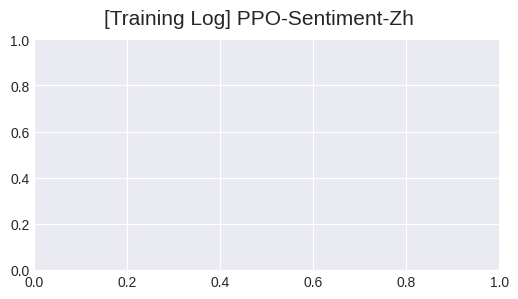

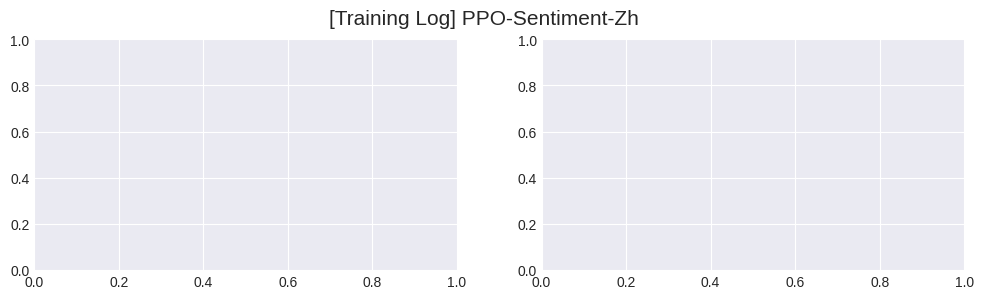

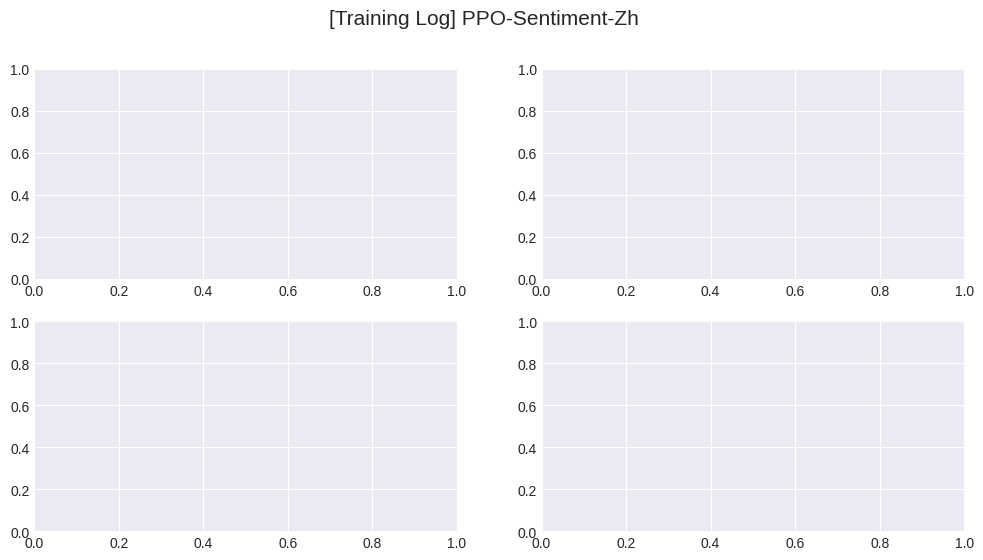

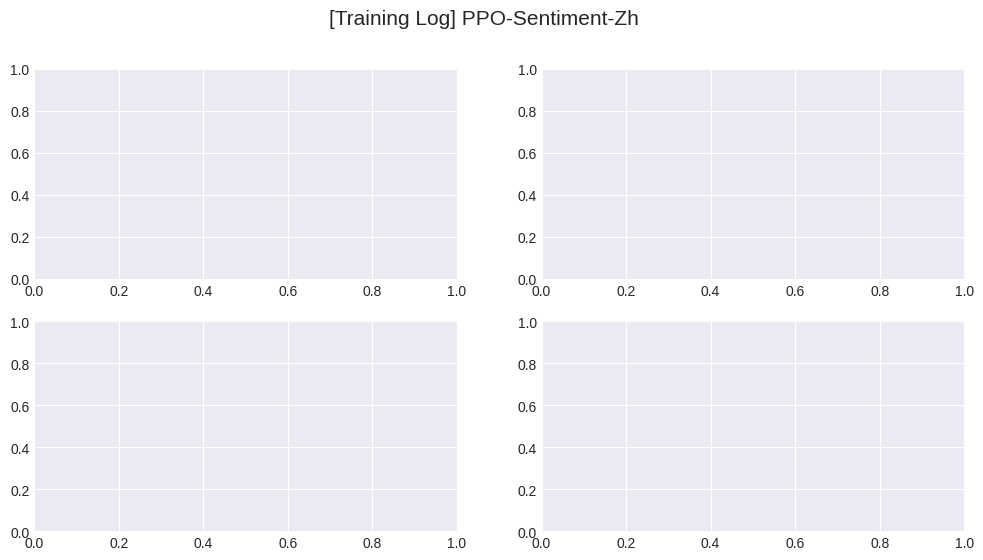

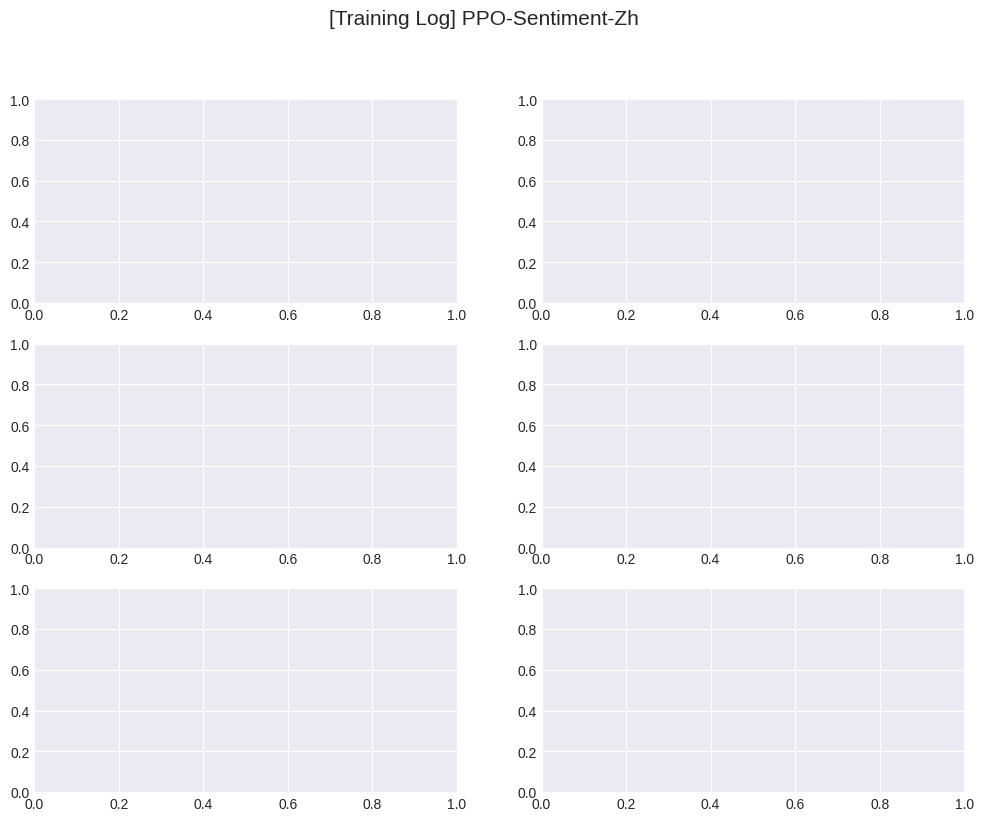

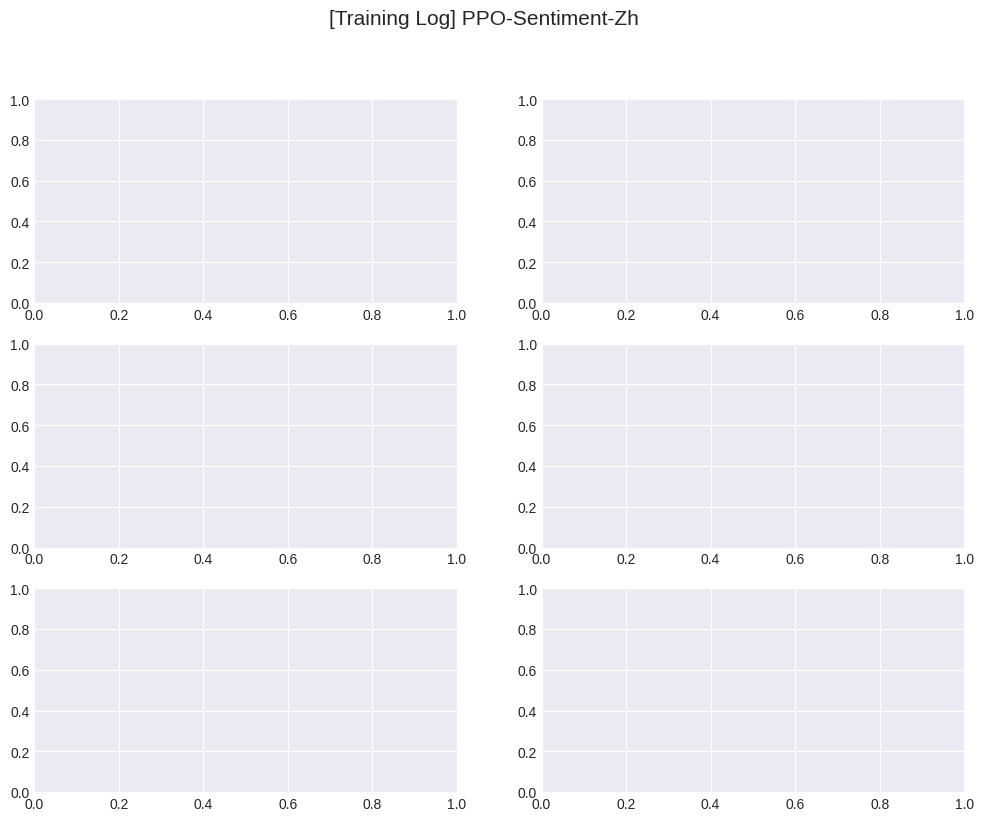

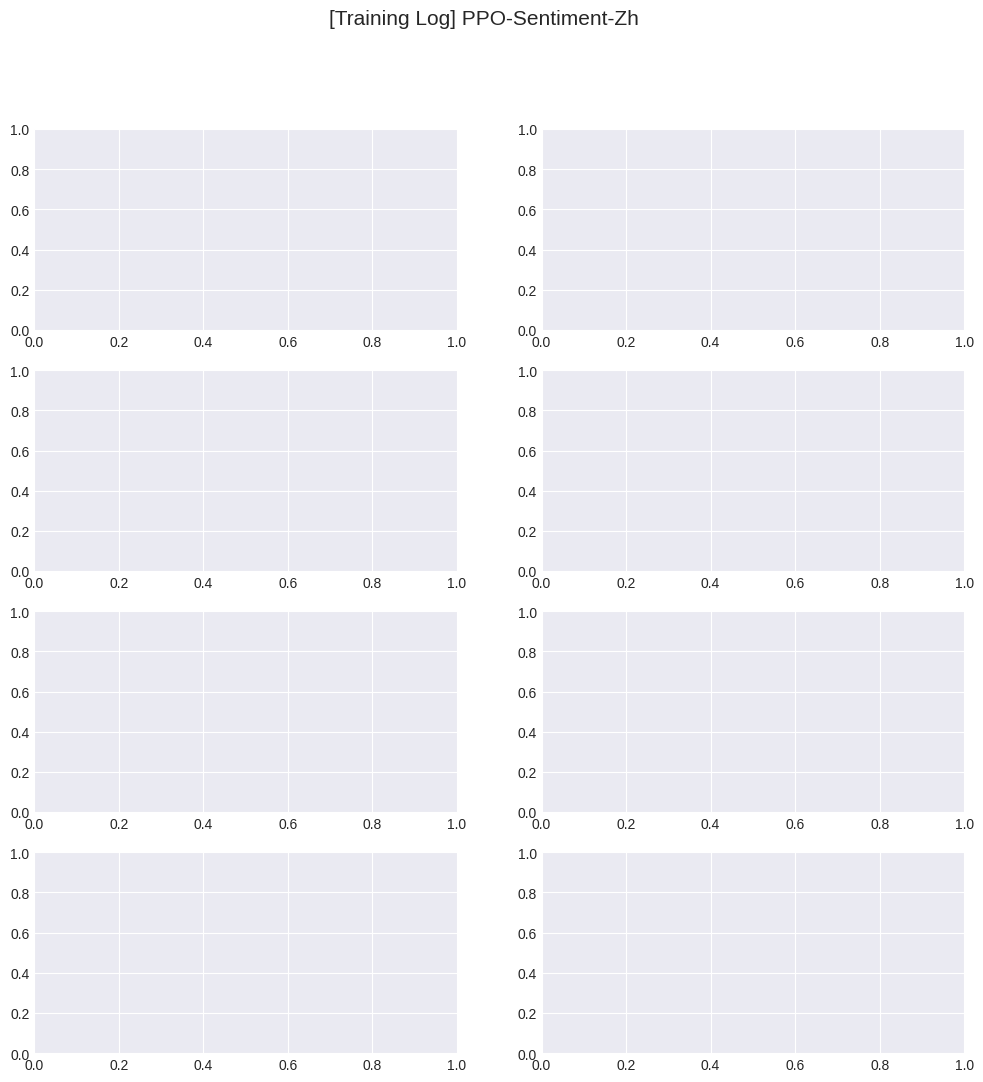

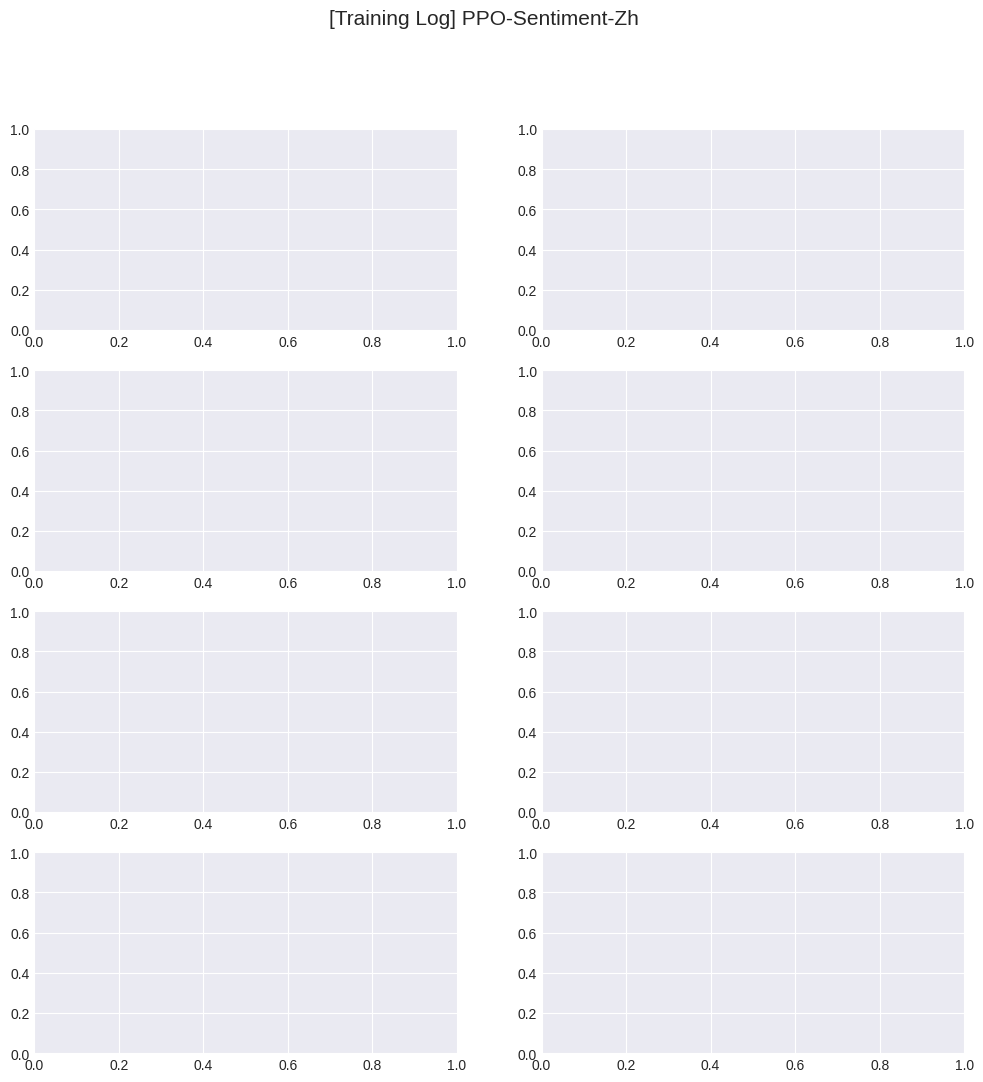

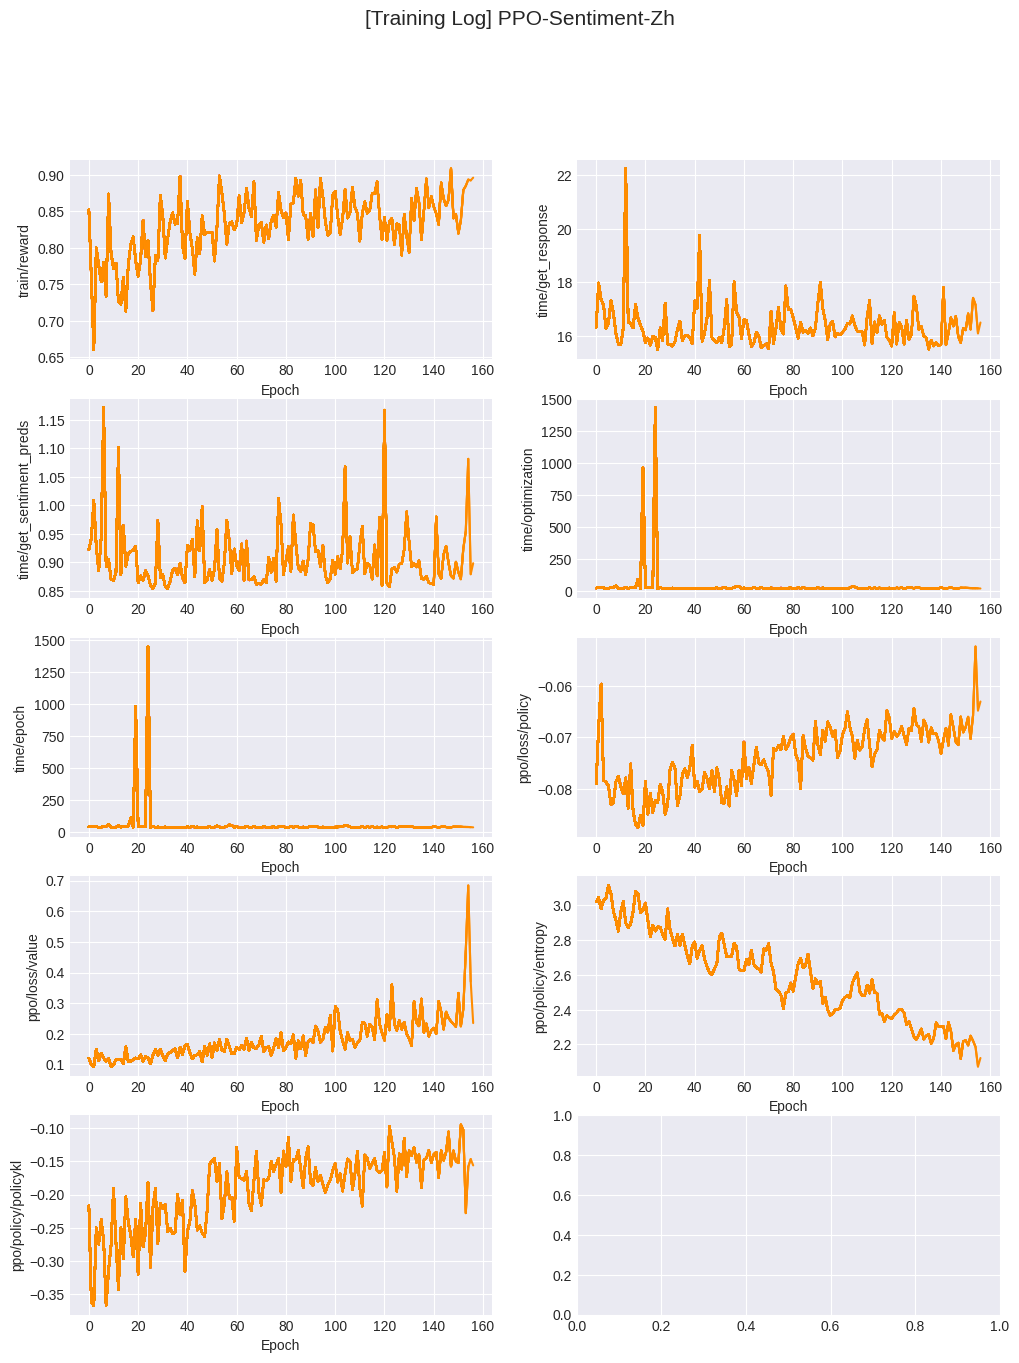

In [13]:
# import importlib
# from importlib import reload
# import mynotes.lib.trl.ppo
# import mynotes.lib.trl.core
# 
# reload(mynotes.lib.trl.ppo)
# reload(mynotes.lib.trl.core)
from mynotes.lib.RLHF.trl.ppo import PPOTrainer

import numpy as np
from tqdm import tqdm
import time
from mynotes.lib.RLHF.iTrainingLogger  import iSummaryWriter


# RL Trainer
ppo_trainer = PPOTrainer(gpt2_model, gpt2_model_ref, gpt2_tokenizer, **config)
total_ppo_epochs = int(np.ceil(config["steps"]/config['batch_size']))

writer = iSummaryWriter(log_path='./mynotes/logs/PPO-Sentiment-Zh', log_name='PPO-Sentiment-Zh')

for epoch in tqdm(range(total_ppo_epochs)):
    logs, timing = dict(), dict()
    t0 = time.time()

    ### rollout
    batch = {
        'tokens': [],
        'query': []
    }
    for _ in range(config['batch_size']):
        random_prompt = random.choice(prompts)                                  # 随机选择一个prompt
        tokens = gpt2_tokenizer.encode(random_prompt)
        batch['tokens'].append(tokens)
        batch['query'].append(random_prompt)
    query_tensors = [torch.tensor(t).long().to(device) for t in batch["tokens"]]

    t = time.time()
    response_tensors = []
    for i in range(config['batch_size']):
        gen_len = config['gen_len']
        response = gpt2_model.generate(query_tensors[i].unsqueeze(dim=0),       # generate()用于直接生成token_id
                                       max_new_tokens=gen_len, **gen_kwargs)
        response_tensors.append(response.squeeze()[-gen_len:])
    batch['response'] = [gpt2_tokenizer.decode(r.squeeze()) for r in response_tensors]
    timing['time/get_response'] = time.time() - t

    t = time.time()
    texts = [q + r for q,r in zip(batch['query'], batch['response'])]           # 计算正向/负向情感得分
    pipe_outputs = sentiment_pipe(texts)
    rewards = []
    for output in pipe_outputs:
        if output['label'] == 'positive (stars 4 and 5)':
            rewards.append(output['score'])
        elif output['label'] == 'negative (stars 1, 2 and 3)':
            rewards.append(1 - output['score'])
        else:
            raise ValueError(f"错误的推理结果{output['label']}.")
    rewards = torch.tensor(rewards).to(device)                                  # 将正向情感的得分作为生成得分
    timing['time/get_sentiment_preds'] = time.time() - t

    ### ppo train
    t = time.time()
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)          # PPO Update
    timing['time/optimization'] = time.time() - t

    ### loging
    timing['time/epoch'] = time.time() - t0                                     # logging
    logs.update(timing)
    logs.update(stats)
    logs['env/reward_mean'] = torch.mean(rewards).cpu().numpy()
    logs['env/reward_std'] = torch.std(rewards).cpu().numpy()
    logs['env/reward_dist'] = rewards.cpu().numpy()
    print(f"epoch {epoch} mean-reward: {logs['env/reward_mean']}")

    print('Random Sample 5 text(s) of model output:')
    for i in range(5):                                                           # 随机打5个生成的结果
        print(f'{i+1}. {random.choice(texts)}')

    writer.add_scalar('train/reward', logs['env/reward_mean'], epoch)
    for k, v in timing.items():
        writer.add_scalar(k, v, epoch)
    writer.add_scalar('ppo/loss/policy', stats['ppo/loss/policy'], epoch)
    writer.add_scalar('ppo/loss/value', stats['ppo/loss/value'], epoch)
    writer.add_scalar('ppo/policy/entropy', stats['ppo/policy/entropy'], epoch)
    writer.add_scalar('ppo/policy/policykl', stats['ppo/policy/policykl'], epoch)
    writer.record()

    if epoch % config['save_freq'] == 0:
        if not os.path.exists(config['save_dir']):
            os.makedirs(config['save_dir'])
        cur_save_path = os.path.join(
            config['save_dir'], f'model_{epoch}_{round(float(logs["env/reward_mean"]), 2)}'
        )
        ppo_trainer.model.save_pretrained(cur_save_path, safe_serialization=False)
        ppo_trainer.tokenizer.save_pretrained(cur_save_path)

# 三、训练reward model
奖励模型训练流程（需要人工标注数据），其步骤如下图所示

<p align=center>
    <img src="./imgs/rewardmodel.jpg" width=800>
</p>
<p align=center>
    <em>image: 训练奖励模型</em>
</p>

数据集一个样本包含若干条评价（用\t隔开），越靠前就越正向，我们期望通过这个序列训练一个 Reward 模型，当句子越偏「正向情绪」时，模型给出的 Reward 越高。数据的形式如下：
```text
1.买过很多箱这个苹果了，一如既往的好，汁多味甜～    2.名不副实。 3.拿过来居然屏幕有划痕，顿时就不开心了    4.什么手机啊！一台充电很慢，信号不好！退了！又买一台竟然是次品。
1.一直用沙宣的洗发露！是正品！去屑止痒润发护发面面俱到！    2.觉得比外买的稀，好似加了水的    3.非常非常不满意，垃圾。   4.什么垃圾衣服，买来一星期不到口袋全拖线，最差的一次购物
...
```

## 1. 损失函数
reword model并不是直接评价一个response的得分，而是生成若干个response，采用排序学习(Learning to rank, LTR)的方法来实现人类偏好排序。因此要用一个rank loss来训练这个模型，这里采用的损失函数相当于LTR的pairwise方式，即必须学到两两配对的偏序关系：
$$loss(\theta) = - \frac{1}{K \choose 2} E_{(x, y_w, y_l) \sim D}[\log(\sigma(r_{\theta}(x,y_w) - r_{\theta}(x,y_l)))] $$
其中$x$表示prompt，$y_w$表示排序排在$y_l$前面的response，$r_{\theta}(x,y)$表示reward model的输出，是一个标量，$\sigma$是sigmoid函数。$K$是产生response的数目，一般是4~9个，${K \choose 2}$是组合数，为$C^2_K$

sigmoid函数会把差值归一化，因此这个损失相当于比较不同两两组合的pair，然后求每个pair的得分之差，将所有pair的损失做平均。

In [3]:
from typing import List
def compute_rank_list_loss(rank_rewards_list: List[List[torch.tensor]], device='cpu') -> torch.Tensor:
    """
    通过给定的有序（从高到低）的ranklist的reward列表，计算rank loss。
    所有排序高的句子的得分减去排序低的句子的得分差的总和，并取负。

    Args:
        rank_rewards_list (torch.tensor): 有序（从高到低）排序句子的reward列表，e.g. -> 
                                        [
                                            [torch.tensor([0.3588]), torch.tensor([0.2481]), ...],
                                            [torch.tensor([0.5343]), torch.tensor([0.2442]), ...],
                                            ...
                                        ]
        device (str): 使用设备

    Returns:
        loss (torch.tensor): tensor([0.4891], grad_fn=<DivBackward0>)
    """
    if type(rank_rewards_list) != list:
        raise TypeError(f'@param rank_rewards expected "list", received {type(rank_rewards_list)}.')

    loss, add_count = torch.tensor([0]).to(device), 0
    for rank_rewards in rank_rewards_list:
        for i in range(len(rank_rewards)-1):                                   # 遍历所有前项-后项的得分差
            for j in range(i+1, len(rank_rewards)):
                diff = F.sigmoid(rank_rewards[i] - rank_rewards[j])            # sigmoid到0~1之间
                loss = loss + diff
                add_count += 1
    loss = loss / add_count                                                     # 求所朋友pair损失的均值
    return -loss  

## 2. Reward Model网络结构
模型结构就是一个LLM，和我们想要训练的模型不是同一个模型。一般选用作为RM的LLM参数都相对较小，只需要在这个训练好的LLM最外层加一个输出层，输出一个标量即可

In [4]:
class RewardModel(nn.Module):

    def __init__(self, encoder):
        """
        init func.

        Args:
            encoder (transformers.AutoModel): backbone, 默认使用 ernie 3.0
        """
        super().__init__()
        self.encoder = encoder
        self.reward_layer = nn.Linear(768, 1)            # reward layer 用于映射到 1 维 reward

    def forward(
        self,
        input_ids: torch.tensor,
        token_type_ids: torch.tensor,
        attention_mask=None,
        pos_ids=None,
    ) -> torch.tensor:
        """
        forward 函数，返回每句话的得分值。

        Args:
            input_ids (torch.tensor): (batch, seq_len)
            token_type_ids (torch.tensor): (batch, seq_len)
            attention_mask (torch.tensor): (batch, seq_len)
            pos_ids (torch.tensor): (batch, seq_len)

        Returns:
            reward: (batch, 1)
        """
        pooler_output = self.encoder(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            position_ids=pos_ids,
            attention_mask=attention_mask,
        )["pooler_output"]                              # (batch, hidden_size)
        reward = self.reward_layer(pooler_output)       # (batch, 1)
        return reward

## 3. 训练

下面是训练参数

In [13]:
from mynotes.lib.RLHF.train_reward_model import train
from mynotes.lib.RLHF.iTrainingLogger import iSummaryWriter
from transformers import AutoTokenizer, AutoModel, default_data_collator, get_scheduler
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--model", default='bert-base-chinese', type=str, help="backbone of encoder.")
parser.add_argument("--train_path", default=None, type=str, help="The path of train set.")
parser.add_argument("--dev_path", default=None, type=str, help="The path of dev set.")
parser.add_argument("--save_dir", default="./checkpoints", type=str, required=False,
                    help="The output directory where the model predictions and checkpoints will be written.")
parser.add_argument("--max_seq_len", default=512, type=int,
                    help="The maximum total input sequence length after tokenization. Sequences longer "
                         "than this will be truncated, sequences shorter will be padded.", )
parser.add_argument("--batch_size", default=16, type=int, help="Batch size per GPU/CPU for training.", )
parser.add_argument("--learning_rate", default=5e-5, type=float, help="The initial learning rate for Adam.")
parser.add_argument("--weight_decay", default=0.0, type=float, help="Weight decay if we apply some.")
parser.add_argument("--num_train_epochs", default=10, type=int, help="Total number of training epochs to perform.")
parser.add_argument("--warmup_ratio", default=0.0, type=float, help="Linear warmup over warmup_ratio * total_steps.")
parser.add_argument("--valid_steps", default=200, type=int, required=False, help="evaluate frequecny.")
parser.add_argument("--logging_steps", default=10, type=int, help="log interval.")
parser.add_argument("--img_log_dir", default='logs', type=str, help="Logging image path.")
parser.add_argument("--img_log_name", default='Model Performance', type=str, help="Logging image file name.")
parser.add_argument('--device', default="cuda:0", help="Select which device to train model, defaults to gpu.")

# 模拟命令行参数
args = parser.parse_args(['--model', 'nghuyong/ernie-3.0-base-zh',
                          '--train_path', './mynotes/data/reward_datasets/sentiment_analysis/train.tsv',
                          '--dev_path', './mynotes/data/reward_datasets/sentiment_analysis/dev.tsv',
                          '--save_dir', './mynotes/checkpoints/reward_model/sentiment_analysis',
                          '--img_log_dir', './mynotes/logs/reward_model/sentiment_analysis',
                          '--img_log_name', 'ERNIE_Reward_Model',
                          '--batch_size', '32',
                          '--max_seq_len', '128',
                          '--learning_rate', '1e-5',
                          '--valid_steps', '50',
                          '--logging_steps', '10',
                          '--num_train_epochs', '10',
                          '--device', 'cuda:0',
                          ])

首先看看数据集：每一行是一个样本，每个样本就是一个排序的序列（用\t分隔开），越排在前面越正向

In [45]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from functools import partial
from mynotes.lib.RLHF.utils import convert_example


tokenizer = AutoTokenizer.from_pretrained(args.model)
dataset = load_dataset('text', data_files={'train': args.train_path,
                                               'dev': args.dev_path})


# 数据转换
convert_func = partial(convert_example, tokenizer=tokenizer, max_seq_len=args.max_seq_len)
dataset = dataset.map(convert_func, batched=True)

print("训练集大小:", len(dataset['train']))
batch = dataset['train'][0: 1]
print('\n\n'.join(batch['text'][0].split('\t')))    # 打印排序
# print(batch.keys())

# 下面是训练示例，对于每个排序中每个评价。需要由RM输出reward
batch_rank_rewards = []
for batch_idx in range(len(batch['input_ids'])):
    rank_texts_count = len(batch['input_ids'][batch_idx])
    rank_rewards = []
    for text_idx in range(rank_texts_count):
        reward = (torch.tensor(0.5).to(args.device),)
        rank_rewards.append(reward[0])          # 每个评价计算reward，这里相当于所有评价都一样
    batch_rank_rewards.append(rank_rewards)     # 一个batch的所有样本的reward_list
loss = compute_rank_list_loss(batch_rank_rewards, device=args.device)   # 计算batch loss
print("loss: ", loss)

The OrderedVocab you are attempting to save contains holes for indices [12084], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [12084], your vocabulary could be corrupted !
训练集大小: 12328
价廉物美，质量不错!，正是我想要的

衣服不错，挺厚实，还有点防雨的感觉

收到了。效果还可以吧。是真的吗？

"国际航班第二日转机, 看了地图感觉还挺近挺新的, 结果去了一看没把我吓尿了, 接驳车司机态度很差,基本不带笑容,问什么爱理不理的,然后酒店内部就更差了,很大味道很严重的发霉味,床铺也很不干净,走道也很脏很阴暗的感觉,总之我感觉是我这辈子住过最垃圾的酒店了,跟格林豪泰那些的都比不上,价格还有300+, 垃圾中的战斗机, 如果你要选这家酒店,三思而后行!!!!!"
loss:  tensor([-0.5000], device='cuda:0')


训练

In [ ]:
# print(args.img_log_dir)
writer = iSummaryWriter(log_path=args.img_log_dir, log_name=args.img_log_name)
encoder = AutoModel.from_pretrained(args.model)
model = RewardModel(encoder=encoder)
train(model, compute_rank_list_loss, writer, args)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 12328
    })
    dev: Dataset({
        features: ['text'],
        num_rows: 3082
    })
})
The OrderedVocab you are attempting to save contains holes for indices [12084], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [12084], your vocabulary could be corrupted !
Start training!
